In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator,LogLocator,MaxNLocator)
from scipy.interpolate import InterpolatedUnivariateSpline as interpolate
from scipy.misc import derivative
import inspect
from scipy.optimize import curve_fit as fit
import scipy.integrate as scint
from scipy.special import spherical_jn as jn
from itertools import groupby
import tqdm
import parmap
import time
import pywigxjpf as wig
from scipy.linalg._matfuncs_sqrtm_triu import within_block_loop
import gmpy2
import mpmath
from scipy import integrate
from joblib import Parallel, delayed

from numba import jit, njit, prange

import sympy as sy
import camb
from ipykernel import kernelapp as app


#plotParameters();
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['mathtext.fontset'] = 'cm'

In [2]:
# definition of Wigner symbols 3j-6j-9j. It works well, but very numerically
# expensive for lmax>20000. Need more than 100 GB to handle lmax=100000, crazy

wig.wig_table_init(40002,3)
wig.wig_temp_init(40002)

def w3j(l1,l2,l3,m1,m2,m3):
    return wig.wig3jj(2*l1, 2*l2, 2*l3, 2*m1, 2*m2, 2*m3)

def w6j(l1,l2,l3,l4,l5,l6):
    return wig.wig6jj(2*l1, 2*l2, 2*l3, 2*l4, 2*l5, 2*l6)

def w9j(l1,l2,l3,l4,l5,l6,l7,l8,l9):
    return wig.wig9jj(2*l1, 2*l2, 2*l3, 2*l4, 2*l5, 2*l6, 2*l7, 2*l8, 2*l9)

In [3]:
# remove the previous Wigner symbols (to be used at the end)

# wig.wig_table_free()
# wig.wig_temp_free()

In [4]:
# low-memory definition of Wigner symbol 3j, valid when m1 = m2 = m3 = 0

def wigner3jm0(l1,l2,l3):
    if l3 >l1+l2 or l3 < np.abs(l1-l2) or (l1+l2+l3) % 2== 1:
        value = 0.
        return value
    else:
        factor1 = mpmath.factorial(l1/2+l2/2+l3/2)
        factor2 = mpmath.factorial(-l1/2+l2/2+l3/2)
        factor3 = mpmath.factorial(l1/2-l2/2+l3/2)
        factor4 = mpmath.factorial(l1/2+l2/2-l3/2)
    
        sq1 = mpmath.sqrt(mpmath.factorial(-l1+l2+l3))
        sq2 = mpmath.sqrt(mpmath.factorial(l1-l2+l3))
        sq3 = mpmath.sqrt(mpmath.factorial(l1+l2-l3))
    
        sq4 = mpmath.sqrt(mpmath.factorial(l1+l2+l3+1))
    
        value = (-1)**(-l1/2-l2/2-l3/2)*factor1*sq1*sq2*sq3/factor2/factor3/factor4/sq4
    
        return float(value)

# IMPORT CMB TRANSFER FUNCTIONS AND POWER SPECTRA

In [5]:
#l, TT, EE, BB, TE
lcmb2,tcmb2,ecmb2,bcmb2,tecmb2 = np.loadtxt('external_data/CMBpower0.01.dat', unpack = True)
lcmb3,tcmb3,ecmb3,bcmb3,tecmb3 = np.loadtxt('external_data/CMBpower0.001.dat', unpack = True)

cmbtrt = np.genfromtxt('external_data/CMB_transfer_tensor.dat')
llist = np.unique(cmbtrt[:,0]).astype(np.int64)
cmbtrt = cmbtrt.reshape(len(llist),len(cmbtrt)//len(llist),5)

cmbtrs = np.genfromtxt('external_data/CMB_transfer_scalar.dat')
llist = np.unique(cmbtrs[:,0]).astype(np.int64)
cmbtrs = cmbtrs.reshape(len(llist),len(cmbtrs)//len(llist),5)

In [6]:
#functions calling CMB PS with correct normalization, in the end we take r = 0.01, nothing really changes

def cTT(i,r):
    l=llist[i]
    if r == 0.01:
        val = tcmb2[i]/(10**12*l*(l+1)/(2*np.pi)*2.7255**2) 
    elif r == 0.001:
        val = tcmb3[i]/(10**12*l*(l+1)/(2*np.pi)*2.7255**2)
    return val


def cEE(i,r):
    l=llist[i]
    if r == 0.01:
        val = ecmb2[i]/(10**12*l*(l+1)/(2*np.pi)*2.7255**2) 
    elif r == 0.001:
        val = ecmb3[i]/(10**12*l*(l+1)/(2*np.pi)*2.7255**2)
    return val


def cET(i,r):
    l=llist[i]
    if r == 0.01:
        val = tecmb2[i]/(10**12*l*(l+1)/(2*np.pi)*2.7255**2) 
    elif r == 0.001:
        val = tecmb3[i]/(10**12*l*(l+1)/(2*np.pi)*2.7255**2)
    return val

# collecting CMB spectra
cTTspectra = np.array([cTT(i,0.01) for i in range(len(llist))])
cEEspectra = np.array([cEE(i,0.01) for i in range(len(llist))])
cETspectra = np.array([cET(i,0.01) for i in range(len(llist))])

# LOAD 21-cm Baryon Transfer from CAMB, Same Cosmology 

In [7]:
pars=camb.set_params(H0=67.32117, ombh2= 0.0223828, omch2= 0.1201075, tau =0.05430842,
                     As= 2.100549e-9, ns= 0.9660499)
#pars=camb.read_ini('planck_2018_acc.ini')

pars.Do21cm  =True

pars.Evolve_delta_xe =True # ionization fraction perturbations
pars.Evolve_baryon_cs  = True # accurate baryon perturbations
pars.WantCls =False
pars.SourceTerms.use_21cm_mK = False # Use dimensionless rather than mK units
redshifts=[30,50,100] # The red-shifts in use in the paper, can change if you want
pars.set_matter_power(kmax=1000., redshifts=redshifts)

# get baryon_etc-transfer functions
results= camb.get_results(pars)
trans = results.get_matter_transfer_data()

def scal_pow(k):
    As = 2.100549e-09
    ns = 0.9660499
    kpivot = 0.05
    pfactor = As*kpivot**(1.-ns)
    return pfactor*k**(ns-1.)

scal_pow(.3), pars.scalar_power(.3)

Note: redshifts have been re-sorted (earliest first)


(1.976580489113523e-09, 1.976580489113523e-09)

In [8]:
# interpolation of baryonic transfer function, for the red-shifts selected
k = trans.transfer_data[0,:,0]*results.Params.h
mono30 = trans.transfer_data[2,:,2]
mono50 = trans.transfer_data[2,:,1]
mono100 = trans.transfer_data[2,:,0]

mono30f=interpolate(k,mono30*k**2,ext=0)

mono50f=interpolate(k,mono50*k**2,ext=0)

mono100f=interpolate(k,mono100*k**2,ext=0)

# DEFINE USEFUL FUNCTIONS 

In [9]:
# Hubble parameter H(z)
def H(z):
    value = results.h_of_z(z)
    return value

# conformal time \eta(z)
def eta(z):
    value = results.conformal_time(z)
    return value

# co-moving distance r(z)
def r(z):
    integrand =  lambda x: 1/H(x)
    int = scint.quad(integrand,0,z)
    return int[0]

# compute co-moving distance at selected red-shifts and recomb
r30 = r(30)
r50 = r(50)
r100 = r(100)
r1100 = r(1100)

# scale factor a(z)
def a(z):
    value = 1/(1+z)
    return value

# dimensionless scalar PS
def scalarpower(q):
    value = 2*np.pi**2*scal_pow(q)/q**3
    return value

# 21-cm transfer from Munoz et. al. arXiv:1506.04152
def trans(qpar,l,r,z):
    if z==30:
        alpha = alp1r(r30)
        T = t21r(r30)
    elif z==50:
        alpha = alp1r(r50)
        T = t21r(r50)
    elif z==100:
        alpha = alp1r(r100)
        T = t21r(r100)
    value = (alpha + T*qpar**2/(qpar**2+l**2/r**2))
    return value

# Omega_m
Omegam = 0.0223828+0.1201075

# Window function 21-cm Fourier space
def Wq(qpar,z,dnu):
    deltaD = 17*np.sqrt((1+z)/10*0.15/Omegam)*dnu/2
    value = np.exp(-qpar**2*deltaD**2/2)
    return value


# radial direction resolution
def deltar(z,dnu):
    return np.sqrt((1+z)/10*0.15/Omegam)*(dnu/0.1)

# Window function 21-cm
def W(rmean,r,z,dnu):
    deltar = 17*np.sqrt((1+z)/10*0.15/Omegam)*dnu
    value = 1/deltar/np.sqrt(2*np.pi)*np.exp(-1/2*(r-rmean)**2/deltar**2)
    return value

In [10]:
np.sqrt(8*np.log(2)), 2 # optional for future: check this factor substitution in Wq definition

(2.3548200450309493, 2)

In [11]:
# importing \alpha(z) and T(z) coefficients, from Floss et. al.:2201.08843

z,a11,a22,a33,a21,a31,a32 = np.loadtxt('external_data/alpha_coefficients_21.dat', unpack = True)
z21,T21 = np.loadtxt('external_data/T21.dat', unpack = True)


listz = np.arange(20,110)
listr = np.array([r(z) for z in listz])

alp1=interpolate(z,a11)
listalp1 = np.array([alp1(z) for z in listz])
alp1r = interpolate(listr,listalp1)

alp2=interpolate(z,a22)
listalp2 = np.array([alp2(z) for z in listz])
alp2r = interpolate(listr,listalp2)

alp3=interpolate(z,a21)
listalp3 = np.array([alp3(z) for z in listz])
alp3r = interpolate(listr,listalp3)


t21=interpolate(z21,T21)
listt21 = np.array([t21(z) for z in listz])
t21r = interpolate(listr,listt21)

In [12]:
# sampling of y for each red-shift, works for Delta_nu < 0.1 MHz. Need to modify 
# ymin and ymax for other frequency resolutions

y30 = np.linspace(r30-7,r30+7,15)
y50 = np.linspace(r50-7,r50+7,15)
y100 = np.linspace(r100-7,r100+7,15)

# sampling of y for each red-shift, works for Delta_nu = 1 MHz. Need to modify 
# ymin and ymax 

y301 = np.linspace(r30-100,r30+100,100)
y501 = np.linspace(r50-100,r50+100,100)
y1001 = np.linspace(r100-100,r100+100,100)

In [13]:
# c parameters describing secondaries 

c1 = 5/7
c2 = 1/2
c3 = 2/7

d0 = c1+c3/3
d2 = 2/3*c3

In [14]:
# ratio between primordial and leading secondary coefficients

def estimation(z):
    value = alp1(z)/(alp2(z)*d0+alp3(z))
    return value

In [15]:
est = np.array([estimation(z) for z in listz])

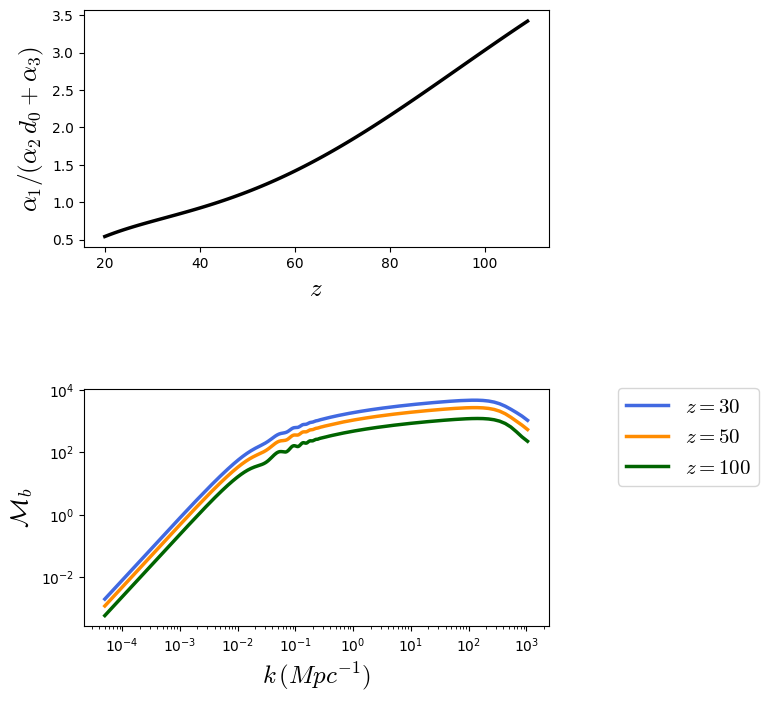

In [16]:
# Plot of ratio between primordial and leading secondary coefficients
# +baryon transfer function

fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))



fig.subplots_adjust(hspace=0.6)



ax1.set_xlabel(r'$z$', fontsize=18)
ax2.set_xlabel(r'$k \, (Mpc^{-1})$', fontsize=18)


ax1.set_ylabel(r'$\alpha_{1}/(\alpha_{2} \, d_0 + \alpha_{3})$', fontsize=18)
ax2.set_ylabel(r'${\cal M}_b$', fontsize=18)

#ax1.set_xscale('log')
ax2.set_xscale('log')

#ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.plot(listz,estimation(listz), linewidth = 2.5,color = 'black', linestyle = '-', zorder = 10)


ax2.plot(k,mono30f(k), label = '$z=30$', color = 'royalblue', linewidth = 2.5, linestyle = '-', zorder = 10)
ax2.plot(k,mono50f(k), label = '$z=50$', color = 'darkorange', linewidth = 2.5, linestyle = '-', zorder = 10)
ax2.plot(k,mono100f(k), label = '$z=100$', color = 'darkgreen', linewidth = 2.5, linestyle = '-', zorder = 10)

ax2.legend(bbox_to_anchor=(1.3, 0.80), loc='center', ncol = 1, borderaxespad=0., fontsize=15)#(loc='best', fontsize=20)


plt.savefig("plots/est.pdf", dpi=300, bbox_inches='tight')


plt.show()
plt.close()

# COMPUTATION OF PRIMORDIAL AND SECONDARY SIGNALS

In [17]:
# CMB k3-integral, <21-21-T>


# primordial I_1
def CMB_prim_I1_T(i,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(l,cmbtrs[i,:,1]*y)*cmbtrs[i,:,2]*scal_pow(cmbtrs[i,:,1])/cmbtrs[i,:,1]
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte

# primordial I_2
def CMB_prim_I2_T(i,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(l,cmbtrs[i,:,1]*y)*cmbtrs[i,:,2]*cmbtrs[i,:,1]**2
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte

# secondary I_1 z=30
def CMB_sec_I1_30_T(i,y):
    l=llist[i]
    integrand = - jn(l,cmbtrs[i,:,1]*y)*cmbtrs[i,:,2]*scal_pow(cmbtrs[i,:,1])*mono30f(cmbtrs[i,:,1])/cmbtrs[i,:,1]
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte

# secondary I_1 z=50
def CMB_sec_I1_50_T(i,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(l,cmbtrs[i,:,1]*y)*cmbtrs[i,:,2]*scal_pow(cmbtrs[i,:,1])*mono50f(cmbtrs[i,:,1])/cmbtrs[i,:,1]
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte

# secondary I_1 z=100
def CMB_sec_I1_100_T(i,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(l,cmbtrs[i,:,1]*y)*cmbtrs[i,:,2]*scal_pow(cmbtrs[i,:,1])*mono100f(cmbtrs[i,:,1])/cmbtrs[i,:,1]
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte

# secondary I_2 z=30
def CMB_sec_I2_30_T(i,L3,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(L3,cmbtrs[i,:,1]*y)*cmbtrs[i,:,2]*scal_pow(cmbtrs[i,:,1])*mono30f(cmbtrs[i,:,1])/cmbtrs[i,:,1]**2
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte

# secondary I_2 z=50
def CMB_sec_I2_50_T(i,L3,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(L3,cmbtrs[i,:,1]*y)*cmbtrs[i,:,2]*scal_pow(cmbtrs[i,:,1])*mono50f(cmbtrs[i,:,1])/cmbtrs[i,:,1]**2
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte

# secondary I_2 z=100
def CMB_sec_I2_100_T(i,L3,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(L3,cmbtrs[i,:,1]*y)*cmbtrs[i,:,2]*scal_pow(cmbtrs[i,:,1])*mono100f(cmbtrs[i,:,1])/cmbtrs[i,:,1]**2
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte



# secondary I_3 z=30
def CMB_sec_I3_30_T(i,L3,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(L3,cmbtrs[i,:,1]*y)*cmbtrs[i,:,2]*scal_pow(cmbtrs[i,:,1])*mono30f(cmbtrs[i,:,1])
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte

# secondary I_3 z=50
def CMB_sec_I3_50_T(i,L3,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(L3,cmbtrs[i,:,1]*y)*cmbtrs[i,:,2]*scal_pow(cmbtrs[i,:,1])*mono50f(cmbtrs[i,:,1])
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte

# secondary I_3 z=100
def CMB_sec_I3_100_T(i,L3,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(L3,cmbtrs[i,:,1]*y)*cmbtrs[i,:,2]*scal_pow(cmbtrs[i,:,1])*mono100f(cmbtrs[i,:,1])
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte




# secondary I_4 z=30
def CMB_sec_I4_30_T(i,L3,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(L3,cmbtrs[i,:,1]*y)*cmbtrs[i,:,2]*scal_pow(cmbtrs[i,:,1])*mono30f(cmbtrs[i,:,1])/cmbtrs[i,:,1]
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte

# secondary I_4 z=50
def CMB_sec_I4_50_T(i,L3,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(L3,cmbtrs[i,:,1]*y)*cmbtrs[i,:,2]*scal_pow(cmbtrs[i,:,1])*mono50f(cmbtrs[i,:,1])/cmbtrs[i,:,1]
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte

# secondary I_4 z=100
def CMB_sec_I4_100_T(i,L3,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(L3,cmbtrs[i,:,1]*y)*cmbtrs[i,:,2]*scal_pow(cmbtrs[i,:,1])*mono100f(cmbtrs[i,:,1])/cmbtrs[i,:,1]
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte



# CMB T-mode PS, just to check normalizations are ok
def CMBspec(i):
    l=llist[i]
    ktr=np.zeros(int(len(cmbtrs[i][:])))
    ctr=np.zeros(int(len(cmbtrs[i][:])))
    for j in range(int(len(cmbtrs[i][:]))):
        ktr[j]=cmbtrs[i][j][1]
        ctr[j]=cmbtrs[i][j][2]
    T=interpolate(ktr,-ctr)
    integrand = lambda q: T(q)**2*scal_pow(q)/q
    qmin = ktr[0]
    qmax = ktr[-1]
    inte = scint.quad(integrand,qmin,qmax, epsabs=0.,epsrel=1e-4, limit = 10000000)[0]
    f =  4*np.pi
    value = f*inte
    return value

In [18]:
# CMB k3-integral, <21-21-E>

# in CAMB we need this additional factor for each E-mode
def factor2(l):
    return (l+2)*(l+1)*l*(l-1)

# primordial I_1
def CMB_prim_I1_E(i,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(l,cmbtrs[i,:,1]*y)*np.sqrt(factor2(l))*cmbtrs[i,:,3]*scal_pow(cmbtrs[i,:,1])/cmbtrs[i,:,1]
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte


# primordial I_2
def CMB_prim_I2_E(i,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(l,cmbtrs[i,:,1]*y)*np.sqrt(factor2(l))*cmbtrs[i,:,3]*cmbtrs[i,:,1]**2
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte


# secondary I_1 z=30
def CMB_sec_I1_30_E(i,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(l,cmbtrs[i,:,1]*y)*np.sqrt(factor2(l))*cmbtrs[i,:,3]*scal_pow(cmbtrs[i,:,1])*mono30f(cmbtrs[i,:,1])/cmbtrs[i,:,1]
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte

# secondary I_1 z=50
def CMB_sec_I1_50_E(i,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(l,cmbtrs[i,:,1]*y)*np.sqrt(factor2(l))*cmbtrs[i,:,3]*scal_pow(cmbtrs[i,:,1])*mono50f(cmbtrs[i,:,1])/cmbtrs[i,:,1]
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte

# secondary I_1 z=100
def CMB_sec_I1_100_E(i,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(l,cmbtrs[i,:,1]*y)*np.sqrt(factor2(l))*cmbtrs[i,:,3]*scal_pow(cmbtrs[i,:,1])*mono100f(cmbtrs[i,:,1])/cmbtrs[i,:,1]
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte



# secondary I_2 z=30
def CMB_sec_I2_30_E(i,L3,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(L3,cmbtrs[i,:,1]*y)*np.sqrt(factor2(l))*cmbtrs[i,:,3]*scal_pow(cmbtrs[i,:,1])*mono30f(cmbtrs[i,:,1])/cmbtrs[i,:,1]**2
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte

# secondary I_2 z=50
def CMB_sec_I2_50_E(i,L3,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(L3,cmbtrs[i,:,1]*y)*np.sqrt(factor2(l))*cmbtrs[i,:,3]*scal_pow(cmbtrs[i,:,1])*mono50f(cmbtrs[i,:,1])/cmbtrs[i,:,1]**2
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte

# secondary I_2 z=100
def CMB_sec_I2_100_E(i,L3,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(L3,cmbtrs[i,:,1]*y)*np.sqrt(factor2(l))*cmbtrs[i,:,3]*scal_pow(cmbtrs[i,:,1])*mono100f(cmbtrs[i,:,1])/cmbtrs[i,:,1]**2
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte



# secondary I_3 z=30
def CMB_sec_I3_30_E(i,L3,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(L3,cmbtrs[i,:,1]*y)*np.sqrt(factor2(l))*cmbtrs[i,:,3]*scal_pow(cmbtrs[i,:,1])*mono30f(cmbtrs[i,:,1])
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte

# secondary I_3 z=50
def CMB_sec_I3_50_E(i,L3,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(L3,cmbtrs[i,:,1]*y)*np.sqrt(factor2(l))*cmbtrs[i,:,3]*scal_pow(cmbtrs[i,:,1])*mono50f(cmbtrs[i,:,1])
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte

# secondary I_3 z=100
def CMB_sec_I3_100_E(i,L3,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(L3,cmbtrs[i,:,1]*y)*np.sqrt(factor2(l))*cmbtrs[i,:,3]*scal_pow(cmbtrs[i,:,1])*mono100f(cmbtrs[i,:,1])
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte




# secondary I_4 z=30
def CMB_sec_I4_30_E(i,L3,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(L3,cmbtrs[i,:,1]*y)*np.sqrt(factor2(l))*cmbtrs[i,:,3]*scal_pow(cmbtrs[i,:,1])*mono30f(cmbtrs[i,:,1])/cmbtrs[i,:,1]
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte

# secondary I_4 z=50
def CMB_sec_I4_50_E(i,L3,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(L3,cmbtrs[i,:,1]*y)*np.sqrt(factor2(l))*cmbtrs[i,:,3]*scal_pow(cmbtrs[i,:,1])*mono50f(cmbtrs[i,:,1])/cmbtrs[i,:,1]
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte

# secondary I_4 z=100
def CMB_sec_I4_100_E(i,L3,y):
    l=llist[i]
    integrand=np.zeros(int(len(cmbtrs[i][:])))
    integrand = - jn(L3,cmbtrs[i,:,1]*y)*np.sqrt(factor2(l))*cmbtrs[i,:,3]*scal_pow(cmbtrs[i,:,1])*mono100f(cmbtrs[i,:,1])/cmbtrs[i,:,1]
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], even='avg')
    return inte

In [19]:
# R-terms as in the paper

# Eq. 49
R30T = np.array([CMB_prim_I1_T(i,r30)**2/cTT(i,0.01)  for i in np.arange(0,20)])
R50T = np.array([CMB_prim_I1_T(i,r50)**2/cTT(i,0.01)  for i in np.arange(0,20)])
R100T = np.array([CMB_prim_I1_T(i,r100)**2/cTT(i,0.01)  for i in np.arange(0,20)])

# Eq. 59
R30ET = np.array([CMB_prim_I1_T(i,r30)**2*cEE(i,0.01)/(cTT(i,0.01)*cEE(i,0.01)-cET(i,0.01)**2)+CMB_prim_I1_E(i,r30)**2*cTT(i,0.01)/(cTT(i,0.01)*cEE(i,0.01)-cET(i,0.01)**2)-2*CMB_prim_I1_T(i,r30)*CMB_prim_I1_E(i,r30)*cET(i,0.01)/(cTT(i,0.01)*cEE(i,0.01)-cET(i,0.01)**2)  for i in np.arange(0,20)])
R50ET = np.array([CMB_prim_I1_T(i,r50)**2*cEE(i,0.01)/(cTT(i,0.01)*cEE(i,0.01)-cET(i,0.01)**2)+CMB_prim_I1_E(i,r50)**2*cTT(i,0.01)/(cTT(i,0.01)*cEE(i,0.01)-cET(i,0.01)**2)-2*CMB_prim_I1_T(i,r50)*CMB_prim_I1_E(i,r50)*cET(i,0.01)/(cTT(i,0.01)*cEE(i,0.01)-cET(i,0.01)**2)  for i in np.arange(0,20)])
R100ET = np.array([CMB_prim_I1_T(i,r100)**2*cEE(i,0.01)/(cTT(i,0.01)*cEE(i,0.01)-cET(i,0.01)**2)+CMB_prim_I1_E(i,r100)**2*cTT(i,0.01)/(cTT(i,0.01)*cEE(i,0.01)-cET(i,0.01)**2)-2*CMB_prim_I1_T(i,r100)*CMB_prim_I1_E(i,r100)*cET(i,0.01)/(cTT(i,0.01)*cEE(i,0.01)-cET(i,0.01)**2)  for i in np.arange(0,20)])

# Eq. 63
R30Tsec = np.array([CMB_sec_I1_30_T(i,r30)**2/cTT(i,0.01)  for i in np.arange(0,20)])
R50Tsec = np.array([CMB_sec_I1_50_T(i,r50)**2/cTT(i,0.01)  for i in np.arange(0,20)])
R100Tsec = np.array([CMB_sec_I1_100_T(i,r100)**2/cTT(i,0.01)  for i in np.arange(0,20)])

# Eq. 64
R30ETsec = np.array([CMB_sec_I1_30_T(i,r30)**2*cEE(i,0.01)/(cTT(i,0.01)*cEE(i,0.01)-cET(i,0.01)**2)+CMB_sec_I1_30_E(i,r30)**2*cTT(i,0.01)/(cTT(i,0.01)*cEE(i,0.01)-cET(i,0.01)**2)-2*CMB_sec_I1_30_T(i,r30)*CMB_sec_I1_30_E(i,r30)*cET(i,0.01)/(cTT(i,0.01)*cEE(i,0.01)-cET(i,0.01)**2)  for i in np.arange(0,20)])
R50ETsec = np.array([CMB_sec_I1_50_T(i,r50)**2*cEE(i,0.01)/(cTT(i,0.01)*cEE(i,0.01)-cET(i,0.01)**2)+CMB_sec_I1_50_E(i,r50)**2*cTT(i,0.01)/(cTT(i,0.01)*cEE(i,0.01)-cET(i,0.01)**2)-2*CMB_sec_I1_50_T(i,r50)*CMB_sec_I1_50_E(i,r50)*cET(i,0.01)/(cTT(i,0.01)*cEE(i,0.01)-cET(i,0.01)**2)  for i in np.arange(0,20)])
R100ETsec = np.array([CMB_sec_I1_100_T(i,r100)**2*cEE(i,0.01)/(cTT(i,0.01)*cEE(i,0.01)-cET(i,0.01)**2)+CMB_sec_I1_100_E(i,r100)**2*cTT(i,0.01)/(cTT(i,0.01)*cEE(i,0.01)-cET(i,0.01)**2)-2*CMB_sec_I1_100_T(i,r100)*CMB_sec_I1_100_E(i,r100)*cET(i,0.01)/(cTT(i,0.01)*cEE(i,0.01)-cET(i,0.01)**2)  for i in np.arange(0,20)])
    

# l for plots
lplot = np.array([i+2  for i in np.arange(0,20)])

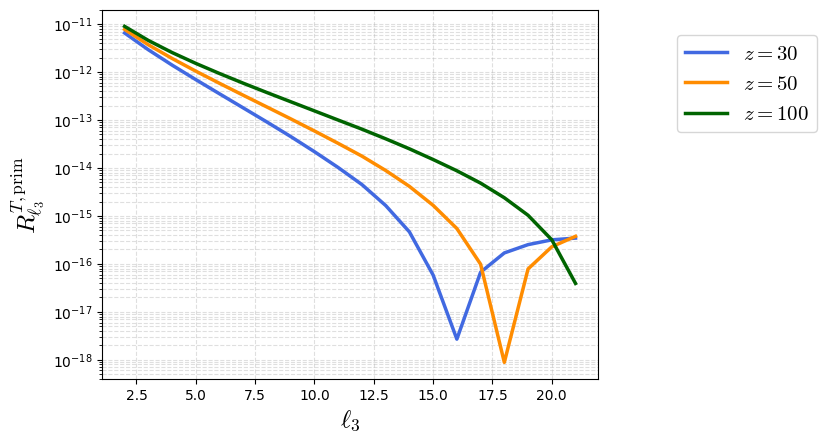

In [20]:
# Plot of R^{T, prim}

plt.figsize=(6, 8)

plt.xlabel(r'$\ell_3$', fontsize=18)


plt.ylabel(r'$R^{T, \rm prim}_{\ell_3}$', fontsize=18)



plt.yscale('log')



plt.plot(lplot,R30T,label = r'$z=30$', color = 'royalblue', linewidth = 2.5, linestyle = '-', zorder = 10)
plt.plot(lplot,R50T,label = r'$z=50$', color = 'darkorange',linewidth = 2.5, linestyle = '-', zorder = 10)
plt.plot(lplot,R100T,label = r'$z=100$', color = 'darkgreen',linewidth = 2.5, linestyle = '-', zorder = 10)

plt.grid(True, which='both',linestyle='--', alpha = 0.4)

plt.legend(bbox_to_anchor=(1.3, 0.80), loc='center', ncol = 1, borderaxespad=0., fontsize=15)#(loc='best', fontsize=20)

plt.savefig("plots/RTpriml3.pdf", dpi=300, bbox_inches='tight')


plt.show()
plt.close()

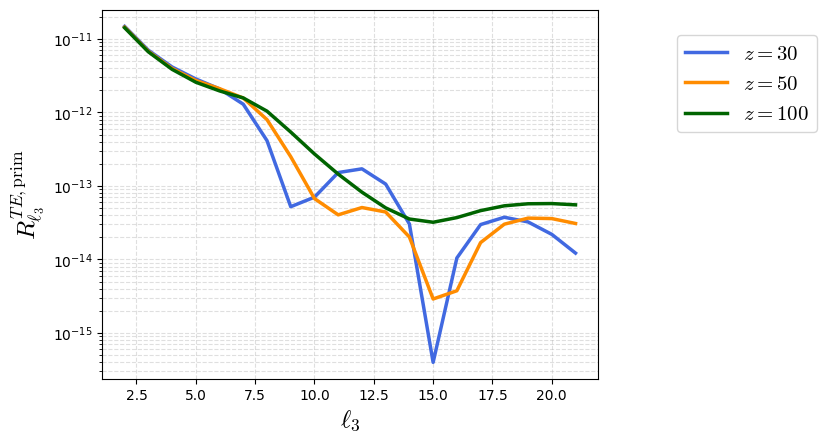

In [21]:
# Plot of R^{TE, prim}

plt.figsize=(6, 8)

plt.xlabel(r'$\ell_3$', fontsize=18)


plt.ylabel(r'$R^{TE, \rm prim}_{\ell_3}$', fontsize=18)



plt.yscale('log')



plt.plot(lplot,R30ET,label = r'$z=30$', color = 'royalblue', linewidth = 2.5, linestyle = '-', zorder = 10)
plt.plot(lplot,R50ET,label = r'$z=50$', color = 'darkorange',linewidth = 2.5, linestyle = '-', zorder = 10)
plt.plot(lplot,R100ET,label = r'$z=100$', color = 'darkgreen',linewidth = 2.5, linestyle = '-', zorder = 10)

plt.grid(True, which='both',linestyle='--', alpha = 0.4)

plt.legend(bbox_to_anchor=(1.3, 0.80), loc='center', ncol = 1, borderaxespad=0., fontsize=15)#(loc='best', fontsize=20)

plt.savefig("plots/RTEpriml3.pdf", dpi=300, bbox_inches='tight')


plt.show()
plt.close()

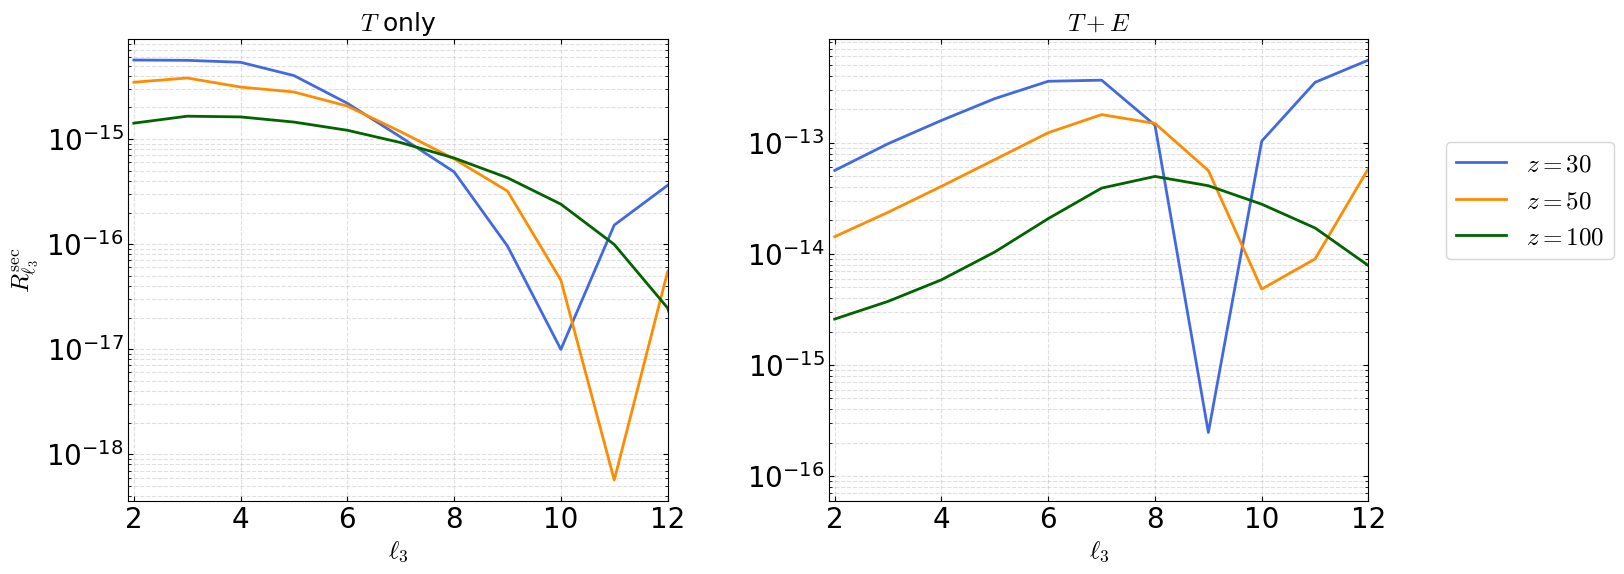

In [31]:
# Plot of R^{T, sec} and R^{ET, sec}

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))




fig.subplots_adjust(hspace=0.7)
fig.subplots_adjust(wspace=0.3)


ax1.set_title(r'$T$ only', fontsize=18)
ax2.set_title(r'$T+E$', fontsize=18)


ax1.set_xlabel(r'$\ell_3$', fontsize=18)
ax2.set_xlabel(r'$\ell_3$', fontsize=18)




ax1.set_xlim(1.9,12)
ax2.set_xlim(1.9,12)


ax1.set_ylabel(r'$R^{\rm sec}_{\ell_3}$', fontsize=18)



ax1.set_yscale('log')
ax2.set_yscale('log')



ax1.plot(lplot,R30Tsec, label = r'$z=30$', color = 'royalblue', linewidth = 2, linestyle = '-', zorder = 10)
ax1.plot(lplot,R50Tsec, label = r'$z=50$', color = 'darkorange', linewidth = 2, linestyle = '-', zorder = 10)
ax1.plot(lplot,R100Tsec, label = r'$z=100$', color = 'darkgreen', linewidth = 2, linestyle = '-', zorder = 10)

ax2.plot(lplot,R30ETsec, label = r'$z=30$', color = 'royalblue', linewidth = 2, linestyle = '-', zorder = 10)
ax2.plot(lplot,R50ETsec, label = r'$z=50$', color = 'darkorange', linewidth = 2, linestyle = '-', zorder = 10)
ax2.plot(lplot,R100ETsec, label = r'$z=100$', color = 'darkgreen', linewidth = 2, linestyle = '-', zorder = 10)


ax2.legend(bbox_to_anchor=(1.30, 0.65), loc='center', ncol = 1, borderaxespad=0., fontsize=18)#(loc='best', fontsize=20)



ax1.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
ax1.grid(True, which='both',linestyle='--', alpha = 0.4)

ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
ax2.grid(True, which='both',linestyle='--', alpha = 0.4)

# plt.ylim([1e-13,7e1])

# ax1.set_ylim([1.4e-6,6.2e-6])
plt.savefig("plots/Rsecvsl3.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [32]:
# l1-l2 sampling

llist2 = np.arange(10000,20001)

# l3 sampling (the same as Fisher forecast)

l3list = np.arange(2,12)
l3list_index = l3list -2

In [33]:
# Creating y-l3 samplings of k3-integrals

CMB_prim_I1_T_y30 = np.array([[CMB_prim_I1_T(i, yp) for yp in y30] for i in l3list_index])
CMB_prim_I1_T_y50 = np.array([[CMB_prim_I1_T(i, yp) for yp in y50] for i in l3list_index])
CMB_prim_I1_T_y100 = np.array([[CMB_prim_I1_T(i, yp) for yp in y100] for i in l3list_index])

CMB_prim_I2_T_y30 = np.array([[CMB_prim_I2_T(i, yp) for yp in y30] for i in l3list_index])
CMB_prim_I2_T_y50 = np.array([[CMB_prim_I2_T(i, yp) for yp in y50] for i in l3list_index])
CMB_prim_I2_T_y100 = np.array([[CMB_prim_I2_T(i, yp) for yp in y100] for i in l3list_index])

CMB_prim_I1_E_y30 = np.array([[CMB_prim_I1_E(i, yp) for yp in y30] for i in l3list_index])
CMB_prim_I1_E_y50 = np.array([[CMB_prim_I1_E(i, yp) for yp in y50] for i in l3list_index])
CMB_prim_I1_E_y100 = np.array([[CMB_prim_I1_E(i, yp) for yp in y100] for i in l3list_index])

CMB_prim_I2_E_y30 = np.array([[CMB_prim_I2_E(i, yp) for yp in y30] for i in l3list_index])
CMB_prim_I2_E_y50 = np.array([[CMB_prim_I2_E(i, yp) for yp in y50] for i in l3list_index])
CMB_prim_I2_E_y100 = np.array([[CMB_prim_I2_E(i, yp) for yp in y100] for i in l3list_index])

CMB_sec_I1_T_y30 = np.array([[CMB_sec_I1_30_T(i, yp) for yp in y30] for i in l3list_index])
CMB_sec_I1_T_y50 = np.array([[CMB_sec_I1_50_T(i, yp) for yp in y50] for i in l3list_index])
CMB_sec_I1_T_y100 = np.array([[CMB_sec_I1_100_T(i, yp) for yp in y100] for i in l3list_index])

CMB_sec_I1_E_y30 = np.array([[CMB_sec_I1_30_E(i, yp) for yp in y30] for i in l3list_index])
CMB_sec_I1_E_y50 = np.array([[CMB_sec_I1_50_E(i, yp) for yp in y50] for i in l3list_index])
CMB_sec_I1_E_y100 = np.array([[CMB_sec_I1_100_E(i, yp) for yp in y100] for i in l3list_index])


def CMB_sec_I2_T_y30(i,L3):
    value = np.array([CMB_sec_I2_30_T(i,L3, yp) for yp in y30])
    return value

def CMB_sec_I2_T_y50(i,L3):
    value = np.array([CMB_sec_I2_50_T(i,L3, yp) for yp in y50])
    return value

def CMB_sec_I2_T_y100(i,L3):
    value = np.array([CMB_sec_I2_100_T(i,L3, yp) for yp in y100])
    return value


def CMB_sec_I2_E_y30(i,L3):
    value = np.array([CMB_sec_I2_30_E(i,L3, yp) for yp in y30])
    return value

def CMB_sec_I2_E_y50(i,L3):
    value = np.array([CMB_sec_I2_50_E(i,L3, yp) for yp in y50])
    return value

def CMB_sec_I2_E_y100(i,L3):
    value = np.array([CMB_sec_I2_100_E(i,L3, yp) for yp in y100])
    return value



def CMB_sec_I3_T_y30(i,L3):
    value = np.array([CMB_sec_I3_30_T(i,L3, yp) for yp in y30])
    return value

def CMB_sec_I3_T_y50(i,L3):
    value = np.array([CMB_sec_I3_50_T(i,L3, yp) for yp in y50])
    return value

def CMB_sec_I3_T_y100(i,L3):
    value = np.array([CMB_sec_I3_100_T(i,L3, yp) for yp in y100])
    return value



def CMB_sec_I3_E_y30(i,L3):
    value = np.array([CMB_sec_I3_30_E(i,L3, yp) for yp in y30])
    return value

def CMB_sec_I3_E_y50(i,L3):
    value = np.array([CMB_sec_I3_50_E(i,L3, yp) for yp in y50])
    return value

def CMB_sec_I3_E_y100(i,L3):
    value = np.array([CMB_sec_I3_100_E(i,L3, yp) for yp in y100])
    return value



def CMB_sec_I4_T_y30(i,L3):
    value = np.array([CMB_sec_I4_30_T(i,L3, yp) for yp in y30])
    return value

def CMB_sec_I4_T_y50(i,L3):
    value = np.array([CMB_sec_I4_50_T(i,L3, yp) for yp in y50])
    return value

def CMB_sec_I4_T_y100(i,L3):
    value = np.array([CMB_sec_I4_100_T(i,L3, yp) for yp in y100])
    return value



def CMB_sec_I4_E_y30(i,L3):
    value = np.array([CMB_sec_I4_30_E(i,L3, yp) for yp in y30])
    return value

def CMB_sec_I4_E_y50(i,L3):
    value = np.array([CMB_sec_I4_50_E(i,L3, yp) for yp in y50])
    return value

def CMB_sec_I4_E_y100(i,L3):
    value = np.array([CMB_sec_I4_100_E(i,L3, yp) for yp in y100])
    return value

In [34]:
# l1-l2-y sampling, k1-, k2-integrations with limber approx

# I1 prim

def Limber21_prim_I1_y30(l1,l2):
    value = np.array([yp*W(r30,yp,30,0.1)**2*alp1r(yp)**2*scal_pow(l2/yp)*mono30f(l1/yp)*mono30f(l2/yp) for yp in y30])
    return value   

def Limber21_prim_I1_y50(l1,l2):
    value = np.array([yp*W(r50,yp,50,0.1)**2*alp1r(yp)**2*scal_pow(l2/yp)*mono50f(l1/yp)*mono50f(l2/yp) for yp in y50])
    return value   

def Limber21_prim_I1_y100(l1,l2):
    value = np.array([yp*W(r100,yp,100,0.1)**2*alp1r(yp)**2*scal_pow(l2/yp)*mono100f(l1/yp)*mono100f(l2/yp) for yp in y100])
    return value   

In [35]:
# l1-l2-y sampling, k1-, k2-integrations with limber approx

# I2 prim


def Limber21_prim_I2_y30(l1,l2):
    value = np.array([yp**4*W(r30,yp,30,0.1)**2*alp1r(yp)**2*scal_pow(l1/yp)*scal_pow(l2/yp)*mono30f(l1/yp)*mono30f(l2/yp) for yp in y30])
    return value   

def Limber21_prim_I2_y50(l1,l2):
    value = np.array([yp**4*W(r50,yp,50,0.1)**2*alp1r(yp)**2*scal_pow(l1/yp)*scal_pow(l2/yp)*mono50f(l1/yp)*mono50f(l2/yp) for yp in y50])
    return value   

def Limber21_prim_I2_y100(l1,l2):
    value = np.array([yp**4*W(r100,yp,100,0.1)**2*alp1r(yp)**2*scal_pow(l1/yp)*scal_pow(l2/yp)*mono100f(l1/yp)*mono100f(l2/yp) for yp in y100])
    return value 

In [36]:
# l1-l2-y sampling, k1-, k2-integrations with limber approx

# I1 sec

def Limber21_sec_I1_y30(l1,l2):
    value = np.array([yp*W(r30,yp,30,0.1)**2*alp1r(yp)*(d0*alp2r(yp)+alp3r(yp))*scal_pow(l2/yp)*mono30f(l2/yp)**2 for yp in y30])
    return value   

def Limber21_sec_I1_y50(l1,l2):
    value = np.array([yp*W(r50,yp,50,0.1)**2*alp1r(yp)*(d0*alp2r(yp)+alp3r(yp))*scal_pow(l2/yp)*mono50f(l2/yp)**2 for yp in y50])
    return value   

def Limber21_sec_I1_y100(l1,l2):
    value = np.array([yp*W(r100,yp,100,0.1)**2*alp1r(yp)*(d0*alp2r(yp)+alp3r(yp))*scal_pow(l2/yp)*mono100f(l2/yp)**2 for yp in y100])
    return value  

In [37]:
# l1-l2-y sampling, k1-, k2-integrations with limber approx

# I2 sec

def Limber21_sec_I2_y30(l1,l2,L2):
    value = np.array([1/L2**2*W(r30,yp,30,0.1)*W(r30,l2/L2*yp,30,0.1)*alp2r(yp)*alp1r(l2/L2*yp)*scal_pow(L2/yp)*mono30f(L2/yp)**2 for yp in y30])
    return value   

def Limber21_sec_I2_y50(l1,l2,L2):
    value = np.array([1/L2**2*W(r50,yp,50,0.1)*W(r50,l2/L2*yp,50,0.1)*alp2r(yp)*alp1r(l2/L2*yp)*scal_pow(L2/yp)*mono50f(L2/yp)**2 for yp in y50])
    return value  

def Limber21_sec_I2_y100(l1,l2,L2):
    value = np.array([1/L2**2*W(r100,yp,100,0.1)*W(r100,l2/L2*yp,100,0.1)*alp2r(yp)*alp1r(l2/L2*yp)*scal_pow(L2/yp)*mono100f(L2/yp)**2 for yp in y100])
    return value  

In [38]:
# l1-l2-y sampling, k1-, k2-integrations with limber approx

# I3 sec


def Limber21_sec_I3_y30(l1,l2,L2):
    value = np.array([1/L2**4*yp**2*W(r30,yp,30,0.1)*W(r30,l2/L2*yp,30,0.1)*alp2r(yp)*alp1r(l2/L2*yp)*scal_pow(L2/yp)*mono30f(L2/yp)**2 for yp in y30])
    return value   

def Limber21_sec_I3_y50(l1,l2,L2):
    value = np.array([1/L2**4*yp**2*W(r50,yp,50,0.1)*W(r50,l2/L2*yp,50,0.1)*alp2r(yp)*alp1r(l2/L2*yp)*scal_pow(L2/yp)*mono50f(L2/yp)**2 for yp in y50])
    return value  

def Limber21_sec_I3_y100(l1,l2,L2):
    value = np.array([1/L2**4*yp**2*W(r100,yp,100,0.1)*W(r100,l2/L2*yp,100,0.1)*alp2r(yp)*alp1r(l2/L2*yp)*scal_pow(L2/yp)*mono100f(L2/yp)**2 for yp in y100])
    return value 

In [39]:
# l1-l2-y sampling, k1-, k2-integrations with limber approx

# I4 sec


def Limber21_sec_I4_y30(l1,l2,L2):
    value = np.array([1/L2**3*yp*W(r30,yp,30,0.1)*W(r30,l2/L2*yp,30,0.1)*alp2r(yp)*alp1r(l2/L2*yp)*scal_pow(L2/yp)*mono30f(L2/yp)**2 for yp in y30])
    return value   

def Limber21_sec_I4_y50(l1,l2,L2):
    value = np.array([1/L2**3*yp*W(r50,yp,50,0.1)*W(r50,l2/L2*yp,50,0.1)*alp2r(yp)*alp1r(l2/L2*yp)*scal_pow(L2/yp)*mono50f(L2/yp)**2 for yp in y50])
    return value  

def Limber21_sec_I4_y100(l1,l2,L2):
    value = np.array([1/L2**3*yp*W(r100,yp,100,0.1)*W(r100,l2/L2*yp,100,0.1)*alp2r(yp)*alp1r(l2/L2*yp)*scal_pow(L2/yp)*mono100f(L2/yp)**2 for yp in y100])
    return value 

In [63]:
# B_21-21-T prim 

# I_1

def B_prim_I1_T_30(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = Limber21_prim_I1_y30(l1,l2)/l2**3 + Limber21_prim_I1_y30(l2,l1)/l1**3
    I2= integrate.simps(CMB_prim_I1_T_y30[l3-2]*cms,x=y30, even='avg')
    value = factor*I2*fI2
    return value


def B_prim_I1_T_50(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = Limber21_prim_I1_y50(l1,l2)/l2**3 + Limber21_prim_I1_y50(l2,l1)/l1**3
    I2= integrate.simps(CMB_prim_I1_T_y50[l3-2]*cms,x=y50, even='avg')
    value = factor*I2*fI2
    return value


def B_prim_I1_T_100(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = Limber21_prim_I1_y100(l1,l2)/l2**3 + Limber21_prim_I1_y100(l2,l1)/l1**3
    I2= integrate.simps(CMB_prim_I1_T_y100[l3-2]*cms,x=y100, even='avg')
    value = factor*I2*fI2
    return value

In [64]:
# B_21-21-T prim 

# I_2

def B_prim_I2_T_30(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = Limber21_prim_I2_y30(l1,l2)/l1**3/l2**3 + Limber21_prim_I2_y30(l2,l1)/l1**3/l2**3
    I2= integrate.simps(CMB_prim_I2_T_y30[l3-2]*cms,x=y30, even='avg')
    value = factor*I2*fI2
    return value


def B_prim_I2_T_50(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = Limber21_prim_I2_y50(l1,l2)/l1**3/l2**3 + Limber21_prim_I2_y50(l2,l1)/l1**3/l2**3
    I2= integrate.simps(CMB_prim_I2_T_y50[l3-2]*cms,x=y50, even='avg')
    value = factor*I2*fI2
    return value


def B_prim_I2_T_100(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = Limber21_prim_I2_y100(l1,l2)/l1**3/l2**3 + Limber21_prim_I2_y100(l2,l1)/l1**3/l2**3
    I2= integrate.simps(CMB_prim_I2_T_y100[l3-2]*cms,x=y100, even='avg')
    value = factor*I2*fI2
    return value

In [65]:
# B_21-21-E prim 

# I_1


def B_prim_I1_E_30(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = Limber21_prim_I1_y30(l1,l2)/l2**3 + Limber21_prim_I1_y30(l2,l1)/l1**3
    I2= integrate.simps(CMB_prim_I1_E_y30[l3-2]*cms,x=y30, even='avg')
    value = factor*I2*fI2
    return value


def B_prim_I1_E_50(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = Limber21_prim_I1_y50(l1,l2)/l2**3 + Limber21_prim_I1_y50(l2,l1)/l1**3
    I2= integrate.simps(CMB_prim_I1_E_y50[l3-2]*cms,x=y50, even='avg')
    value = factor*I2*fI2
    return value


def B_prim_I1_E_100(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = Limber21_prim_I1_y100(l1,l2)/l2**3 + Limber21_prim_I1_y100(l2,l1)/l1**3
    I2= integrate.simps(CMB_prim_I1_E_y100[l3-2]*cms,x=y100, even='avg')
    value = factor*I2*fI2
    return value

In [66]:
# B_21-21-E prim 

# I_2


def B_prim_I2_E_30(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = Limber21_prim_I2_y30(l1,l2)/l1**3/l2**3 + Limber21_prim_I2_y30(l2,l1)/l1**3/l2**3
    I2= integrate.simps(CMB_prim_I2_E_y30[l3-2]*cms,x=y30, even='avg')
    value = factor*I2*fI2
    return value


def B_prim_I2_E_50(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = Limber21_prim_I2_y50(l1,l2)/l1**3/l2**3 + Limber21_prim_I2_y50(l2,l1)/l1**3/l2**3
    I2= integrate.simps(CMB_prim_I2_E_y50[l3-2]*cms,x=y50, even='avg')
    value = factor*I2*fI2
    return value


def B_prim_I2_E_100(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = Limber21_prim_I2_y100(l1,l2)/l1**3/l2**3 + Limber21_prim_I2_y100(l2,l1)/l1**3/l2**3
    I2= integrate.simps(CMB_prim_I2_E_y100[l3-2]*cms,x=y100, even='avg')
    value = factor*I2*fI2
    return value

In [67]:
# B_21-21-T sec 

# I_1

def B_sec_I1_T_30(l1,l2,l3):
    factor = 64*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = Limber21_sec_I1_y30(l1,l2)/l2**3 + Limber21_sec_I1_y30(l2,l1)/l1**3
    I2= integrate.simps(CMB_sec_I1_T_y30[l3-2]*cms,x=y30, even='avg')
    value = factor*I2*fI2
    return value

def B_sec_I1_T_50(l1,l2,l3):
    factor = 64*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = Limber21_sec_I1_y50(l1,l2)/l2**3 + Limber21_sec_I1_y50(l2,l1)/l1**3
    I2= integrate.simps(CMB_sec_I1_T_y50[l3-2]*cms,x=y50, even='avg')
    value = factor*I2*fI2
    return value


def B_sec_I1_T_100(l1,l2,l3):
    factor = 64*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = Limber21_sec_I1_y100(l1,l2)/l2**3 + Limber21_sec_I1_y100(l2,l1)/l1**3
    I2= integrate.simps(CMB_sec_I1_T_y100[l3-2]*cms,x=y100, even='avg')
    value = factor*I2*fI2
    return value

In [68]:
# B_21-21-E sec

# I_1

def B_sec_I1_E_30(l1,l2,l3):
    factor = 64*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = Limber21_sec_I1_y30(l1,l2)/l2**3 + Limber21_sec_I1_y30(l2,l1)/l1**3
    I2= integrate.simps(CMB_sec_I1_E_y30[l3-2]*cms,x=y30, even='avg')
    value = factor*I2*fI2
    return value

def B_sec_I1_E_50(l1,l2,l3):
    factor = 64*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = Limber21_sec_I1_y50(l1,l2)/l2**3 + Limber21_sec_I1_y50(l2,l1)/l1**3
    I2= integrate.simps(CMB_sec_I1_E_y50[l3-2]*cms,x=y50, even='avg')
    value = factor*I2*fI2
    return value


def B_sec_I1_E_100(l1,l2,l3):
    factor = 64*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = Limber21_sec_I1_y100(l1,l2)/l2**3 + Limber21_sec_I1_y100(l2,l1)/l1**3
    I2= integrate.simps(CMB_sec_I1_E_y100[l3-2]*cms,x=y100, even='avg')
    value = factor*I2*fI2
    return value

In [69]:
# B_21-21-T sec 

# I_2

def B_sec_I2_T_30(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = Limber21_sec_I2_y30(l1,l2,ltwo)/l2 + Limber21_sec_I2_y30(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMB_sec_I2_T_y30(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y30, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2
    return value.real



def B_sec_I2_T_50(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = Limber21_sec_I2_y50(l1,l2,ltwo)/l2 + Limber21_sec_I2_y50(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMB_sec_I2_T_y50(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y50, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2
    return value.real


def B_sec_I2_T_100(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = Limber21_sec_I2_y100(l1,l2,ltwo)/l2 + Limber21_sec_I2_y100(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMB_sec_I2_T_y100(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y100, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2
    return value.real

In [70]:
# B_21-21-E sec

# I_2

def B_sec_I2_E_30(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = Limber21_sec_I2_y30(l1,l2,ltwo)/l2 + Limber21_sec_I2_y30(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMB_sec_I2_E_y30(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y30, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2
    return value.real



def B_sec_I2_E_50(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = Limber21_sec_I2_y50(l1,l2,ltwo)/l2 + Limber21_sec_I2_y50(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMB_sec_I2_E_y50(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y50, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2
    return value.real


def B_sec_I2_E_100(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = Limber21_sec_I2_y100(l1,l2,ltwo)/l2 + Limber21_sec_I2_y100(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMB_sec_I2_E_y100(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y100, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2
    return value.real

In [71]:
# B_21-21-T sec 

# I_3

def B_sec_I3_T_30(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = Limber21_sec_I3_y30(l1,l2,ltwo)/l2 + Limber21_sec_I3_y30(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMB_sec_I3_T_y30(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y30, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2
    return value.real



def B_sec_I3_T_50(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = Limber21_sec_I3_y50(l1,l2,ltwo)/l2 + Limber21_sec_I3_y50(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMB_sec_I3_T_y50(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y50, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2
    return value.real


def B_sec_I3_T_100(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = Limber21_sec_I3_y100(l1,l2,ltwo)/l2 + Limber21_sec_I3_y100(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMB_sec_I3_T_y100(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y100, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2
    return value.real

In [72]:
# B_21-21-E sec 

# I_3

def B_sec_I3_E_30(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = Limber21_sec_I3_y30(l1,l2,ltwo)/l2 + Limber21_sec_I3_y30(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMB_sec_I3_E_y30(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y30, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2
    return value.real



def B_sec_I3_E_50(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = Limber21_sec_I3_y50(l1,l2,ltwo)/l2 + Limber21_sec_I3_y50(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMB_sec_I3_E_y50(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y50, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2
    return value.real


def B_sec_I3_E_100(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = Limber21_sec_I3_y100(l1,l2,ltwo)/l2 + Limber21_sec_I3_y100(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMB_sec_I3_E_y100(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y100, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2
    return value.real

In [73]:
# B_21-21-T sec 

# I_4

def B_sec_I4_T_30(l1,l2,l3):
    factor = 2/3*64*c3*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-2,l2,l2+2]
    L3 = [l3-2,l3,l3+2]
    I2 = 0   
    for ltwo in L2:
        cms = Limber21_sec_I4_y30(l1,l2,ltwo)/l2 + Limber21_sec_I4_y30(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMB_sec_I4_T_y30(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y30, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,2)*wigner3jm0(l3,lthree,2)*w6j(l1,l2,l3,2,lthree,ltwo)
    value = factor*I2*fI2
    return value.real


def B_sec_I4_T_50(l1,l2,l3):
    factor = 2/3*64*c3*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-2,l2,l2+2]
    L3 = [l3-2,l3,l3+2]
    I2 = 0   
    for ltwo in L2:
        cms = Limber21_sec_I4_y50(l1,l2,ltwo)/l2 + Limber21_sec_I4_y50(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMB_sec_I4_T_y50(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y50, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,2)*wigner3jm0(l3,lthree,2)*w6j(l1,l2,l3,2,lthree,ltwo)
    value = factor*I2*fI2
    return value.real


def B_sec_I4_T_100(l1,l2,l3):
    factor = 2/3*64*c3*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-2,l2,l2+2]
    L3 = [l3-2,l3,l3+2]
    I2 = 0   
    for ltwo in L2:
        cms = Limber21_sec_I4_y100(l1,l2,ltwo)/l2 + Limber21_sec_I4_y100(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMB_sec_I4_T_y100(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y100, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,2)*wigner3jm0(l3,lthree,2)*w6j(l1,l2,l3,2,lthree,ltwo)
    value = factor*I2*fI2
    return value.real

In [74]:
# B_21-21-E sec 

# I_4

def B_sec_I4_E_30(l1,l2,l3):
    factor = 2/3*64*c3*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-2,l2,l2+2]
    L3 = [l3-2,l3,l3+2]
    I2 = 0   
    for ltwo in L2:
        cms = Limber21_sec_I4_y30(l1,l2,ltwo)/l2 + Limber21_sec_I4_y30(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMB_sec_I4_E_y30(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y30, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,2)*wigner3jm0(l3,lthree,2)*w6j(l1,l2,l3,2,lthree,ltwo)
    value = factor*I2*fI2
    return value.real


def B_sec_I4_E_50(l1,l2,l3):
    factor = 2/3*64*c3*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-2,l2,l2+2]
    L3 = [l3-2,l3,l3+2]
    I2 = 0   
    for ltwo in L2:
        cms = Limber21_sec_I4_y50(l1,l2,ltwo)/l2 + Limber21_sec_I4_y50(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMB_sec_I4_E_y50(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y50, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,2)*wigner3jm0(l3,lthree,2)*w6j(l1,l2,l3,2,lthree,ltwo)
    value = factor*I2*fI2
    return value.real


def B_sec_I4_E_100(l1,l2,l3):
    factor = 2/3*64*c3*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-2,l2,l2+2]
    L3 = [l3-2,l3,l3+2]
    I2 = 0   
    for ltwo in L2:
        cms = Limber21_sec_I4_y100(l1,l2,ltwo)/l2 + Limber21_sec_I4_y100(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMB_sec_I4_E_y100(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y100, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,2)*wigner3jm0(l3,lthree,2)*w6j(l1,l2,l3,2,lthree,ltwo)
    value = factor*I2*fI2
    return value.real

In [75]:
# Slicings I1-prim <21-21-T>

Bprim30_ll = [B_prim_I1_T_30(10000,10000, l3) for l3 in l3list if l3%2==0]
Bprim50_ll = [B_prim_I1_T_50(10000,10000, l3) for l3 in l3list if l3%2==0]
Bprim100_ll = [B_prim_I1_T_100(10000,10000, l3) for l3 in l3list if l3%2==0]

Bprim30_ll2 = [B_prim_I1_T_30(10000,10002, l3) for l3 in l3list if l3%2==0]
Bprim50_ll2 = [B_prim_I1_T_50(10000,10002, l3) for l3 in l3list if l3%2==0]
Bprim100_ll2 = [B_prim_I1_T_100(10000,10002, l3) for l3 in l3list if l3%2==0]

Bprim30_ll4 = [B_prim_I1_T_30(10000,10004, l3) for l3 in l3list if l3%2==0]
Bprim50_ll4 = [B_prim_I1_T_50(10000,10004, l3) for l3 in l3list if l3%2==0]
Bprim100_ll4 = [B_prim_I1_T_100(10000,10004, l3) for l3 in l3list if l3%2==0]


Bprim30_ll6 = [B_prim_I1_T_30(10000,10006, l3) for l3 in l3list if l3%2==0]
Bprim50_ll6 = [B_prim_I1_T_50(10000,10006, l3) for l3 in l3list if l3%2==0]
Bprim100_ll6 = [B_prim_I1_T_100(10000,10006, l3) for l3 in l3list if l3%2==0]

Bprim30_ll8 = [B_prim_I1_T_30(10000,10008, l3) for l3 in l3list if l3%2==0]
Bprim50_ll8 = [B_prim_I1_T_50(10000,10008, l3) for l3 in l3list if l3%2==0]
Bprim100_ll8 = [B_prim_I1_T_100(10000,10008, l3) for l3 in l3list if l3%2==0]

Bprim30_ll10 = [B_prim_I1_T_30(10000,10010, l3) for l3 in l3list if l3%2==0]
Bprim50_ll10 = [B_prim_I1_T_50(10000,10010, l3) for l3 in l3list if l3%2==0]
Bprim100_ll10 = [B_prim_I1_T_100(10000,10010, l3) for l3 in l3list if l3%2==0]




Bprim30_ll1 = [B_prim_I1_T_30(10000,10001, l3) for l3 in l3list if l3%2==1]
Bprim50_ll1 = [B_prim_I1_T_50(10000,10001, l3) for l3 in l3list if l3%2==1]
Bprim100_ll1 = [B_prim_I1_T_100(10000,10001, l3) for l3 in l3list if l3%2==1]

Bprim30_ll3 = [B_prim_I1_T_30(10000,10003, l3) for l3 in l3list if l3%2==1]
Bprim50_ll3 = [B_prim_I1_T_50(10000,10003, l3) for l3 in l3list if l3%2==1]
Bprim100_ll3 = [B_prim_I1_T_100(10000,10003, l3) for l3 in l3list if l3%2==1]

Bprim30_ll5 = [B_prim_I1_T_30(10000,10005, l3) for l3 in l3list if l3%2==1]
Bprim50_ll5 = [B_prim_I1_T_50(10000,10005, l3) for l3 in l3list if l3%2==1]
Bprim100_ll5 = [B_prim_I1_T_100(10000,10005, l3) for l3 in l3list if l3%2==1]

Bprim30_ll7 = [B_prim_I1_T_30(10000,10007, l3) for l3 in l3list if l3%2==1]
Bprim50_ll7 = [B_prim_I1_T_50(10000,10007, l3) for l3 in l3list if l3%2==1]
Bprim100_ll7 = [B_prim_I1_T_100(10000,10007, l3) for l3 in l3list if l3%2==1]

Bprim30_ll9 = [B_prim_I1_T_30(10000,10009, l3) for l3 in l3list if l3%2==1]
Bprim50_ll9 = [B_prim_I1_T_50(10000,10009, l3) for l3 in l3list if l3%2==1]
Bprim100_ll9 = [B_prim_I1_T_100(10000,10009, l3) for l3 in l3list if l3%2==1]

Bprim30_ll11 = [B_prim_I1_T_30(10000,10011, l3) for l3 in l3list if l3%2==1]
Bprim50_ll11 = [B_prim_I1_T_50(10000,10011, l3) for l3 in l3list if l3%2==1]
Bprim100_ll11 = [B_prim_I1_T_100(10000,10011, l3) for l3 in l3list if l3%2==1]

In [76]:
# Slicings I2-prim <21-21-T>

Bprim230_ll = [B_prim_I2_T_30(10000,10000, l3) for l3 in l3list if l3%2==0]
Bprim250_ll = [B_prim_I2_T_50(10000,10000, l3) for l3 in l3list if l3%2==0]
Bprim2100_ll = [B_prim_I2_T_100(10000,10000, l3) for l3 in l3list if l3%2==0]


Bprim230_ll1 = [B_prim_I2_T_30(10000,10001, l3) for l3 in l3list if l3%2==1]
Bprim250_ll1 = [B_prim_I2_T_50(10000,10001, l3) for l3 in l3list if l3%2==1]
Bprim2100_ll1 = [B_prim_I2_T_100(10000,10001, l3) for l3 in l3list if l3%2==1]

# Slicings I1-sec <21-21-T>

Bsec130_ll = [B_sec_I1_T_30(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec150_ll = [B_sec_I1_T_50(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec1100_ll = [B_sec_I1_T_100(10000,10000,l3) for l3 in l3list if l3%2==0]

Bsec130_ll1 = [B_sec_I1_T_30(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec150_ll1 = [B_sec_I1_T_50(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec1100_ll1 = [B_sec_I1_T_100(10000,10001,l3) for l3 in l3list if l3%2==1]

# Slicings I2-sec <21-21-T>

Bsec230_ll = [B_sec_I2_T_30(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec250_ll = [B_sec_I2_T_50(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec2100_ll = [B_sec_I2_T_100(10000,10000,l3) for l3 in l3list if l3%2==0]

Bsec230_ll1 = [B_sec_I2_T_30(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec250_ll1 = [B_sec_I2_T_50(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec2100_ll1 = [B_sec_I2_T_100(10000,10001,l3) for l3 in l3list if l3%2==1]

# Slicings I3-sec <21-21-T>

Bsec330_ll = [B_sec_I3_T_30(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec350_ll = [B_sec_I3_T_50(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec3100_ll = [B_sec_I3_T_100(10000,10000,l3) for l3 in l3list if l3%2==0]

Bsec330_ll1 = [B_sec_I3_T_30(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec350_ll1 = [B_sec_I3_T_50(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec3100_ll1 = [B_sec_I3_T_100(10000,10001,l3) for l3 in l3list if l3%2==1]

# Slicings I4-sec <21-21-T>

Bsec430_ll = [B_sec_I4_T_30(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec450_ll = [B_sec_I4_T_50(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec4100_ll = [B_sec_I4_T_100(10000,10000,l3) for l3 in l3list if l3%2==0]

Bsec430_ll1 = [B_sec_I4_T_30(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec450_ll1 = [B_sec_I4_T_50(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec4100_ll1 = [B_sec_I4_T_100(10000,10001,l3) for l3 in l3list if l3%2==1]

In [77]:
# Slicings I2-prim <21-21-E>

Bprim230pol_ll = [B_prim_I2_E_30(10000,10000, l3) for l3 in l3list if l3%2==0]
Bprim250pol_ll = [B_prim_I2_E_50(10000,10000, l3) for l3 in l3list if l3%2==0]
Bprim2100pol_ll = [B_prim_I2_E_100(10000,10000, l3) for l3 in l3list if l3%2==0]


Bprim230pol_ll1 = [B_prim_I2_E_30(10000,10001, l3) for l3 in l3list if l3%2==1]
Bprim250pol_ll1 = [B_prim_I2_E_50(10000,10001, l3) for l3 in l3list if l3%2==1]
Bprim2100pol_ll1 = [B_prim_I2_E_100(10000,10001, l3) for l3 in l3list if l3%2==1]

# Slicings I1-sec <21-21-E>

Bsec130pol_ll = [B_sec_I1_E_30(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec150pol_ll = [B_sec_I1_E_50(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec1100pol_ll = [B_sec_I1_E_100(10000,10000,l3) for l3 in l3list if l3%2==0]

Bsec130pol_ll1 = [B_sec_I1_E_30(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec150pol_ll1 = [B_sec_I1_E_50(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec1100pol_ll1 = [B_sec_I1_E_100(10000,10001,l3) for l3 in l3list if l3%2==1]

# Slicings I2-sec <21-21-E>

Bsec230pol_ll = [B_sec_I2_E_30(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec250pol_ll = [B_sec_I2_E_50(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec2100pol_ll = [B_sec_I2_E_100(10000,10000,l3) for l3 in l3list if l3%2==0]

Bsec230pol_ll1 = [B_sec_I2_E_30(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec250pol_ll1 = [B_sec_I2_E_50(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec2100pol_ll1 = [B_sec_I2_E_100(10000,10001,l3) for l3 in l3list if l3%2==1]

# Slicings I3-sec <21-21-E>

Bsec330pol_ll = [B_sec_I3_E_30(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec350pol_ll = [B_sec_I3_E_50(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec3100pol_ll = [B_sec_I3_E_100(10000,10000,l3) for l3 in l3list if l3%2==0]

Bsec330pol_ll1 = [B_sec_I3_E_30(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec350pol_ll1 = [B_sec_I3_E_50(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec3100pol_ll1 = [B_sec_I3_E_100(10000,10001,l3) for l3 in l3list if l3%2==1]

# Slicings I4-sec <21-21-E>

Bsec430pol_ll = [B_sec_I4_E_30(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec450pol_ll = [B_sec_I4_E_50(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec4100pol_ll = [B_sec_I4_E_100(10000,10000,l3) for l3 in l3list if l3%2==0]

Bsec430pol_ll1 = [B_sec_I4_E_30(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec450pol_ll1 = [B_sec_I4_E_50(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec4100pol_ll1 = [B_sec_I4_E_100(10000,10001,l3) for l3 in l3list if l3%2==1]


In [78]:
# Slicings full-sec <21-21-T>

Bsec30_ll = [B_sec_I1_T_30(10000,10000,l3)+B_sec_I2_T_30(10000,10000,l3)+B_sec_I3_T_30(10000,10000,l3)+B_sec_I4_T_30(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec50_ll = [B_sec_I1_T_50(10000,10000,l3)+B_sec_I2_T_50(10000,10000,l3)+B_sec_I3_T_50(10000,10000,l3)+B_sec_I4_T_50(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec100_ll = [B_sec_I1_T_100(10000,10000,l3)+B_sec_I2_T_100(10000,10000,l3)+B_sec_I3_T_100(10000,10000,l3)+B_sec_I4_T_100(10000,10000,l3) for l3 in l3list if l3%2==0]

Bsec30_ll2 = [B_sec_I1_T_30(10000,10002,l3)+B_sec_I2_T_30(10000,10002,l3)+B_sec_I3_T_30(10000,10002,l3)+B_sec_I4_T_30(10000,10002,l3) for l3 in l3list if l3%2==0]
Bsec50_ll2 = [B_sec_I1_T_50(10000,10002,l3)+B_sec_I2_T_50(10000,10002,l3)+B_sec_I3_T_50(10000,10002,l3)+B_sec_I4_T_50(10000,10002,l3) for l3 in l3list if l3%2==0]
Bsec100_ll2 = [B_sec_I1_T_100(10000,10002,l3)+B_sec_I2_T_100(10000,10002,l3)+B_sec_I3_T_100(10000,10002,l3)+B_sec_I4_T_100(10000,10002,l3) for l3 in l3list if l3%2==0]

Bsec30_ll4 = [B_sec_I1_T_30(10000,10004,l3)+B_sec_I2_T_30(10000,10004,l3)+B_sec_I3_T_30(10000,10004,l3)+B_sec_I4_T_30(10000,10004,l3) for l3 in l3list if l3%2==0]
Bsec50_ll4 = [B_sec_I1_T_50(10000,10004,l3)+B_sec_I2_T_50(10000,10004,l3)+B_sec_I3_T_50(10000,10004,l3)+B_sec_I4_T_50(10000,10004,l3) for l3 in l3list if l3%2==0]
Bsec100_ll4 = [B_sec_I1_T_100(10000,10004,l3)+B_sec_I2_T_100(10000,10004,l3)+B_sec_I3_T_100(10000,10004,l3)+B_sec_I4_T_100(10000,10004,l3) for l3 in l3list if l3%2==0]

Bsec30_ll6 = [B_sec_I1_T_30(10000,10006,l3)+B_sec_I2_T_30(10000,10006,l3)+B_sec_I3_T_30(10000,10006,l3)+B_sec_I4_T_30(10000,10006,l3) for l3 in l3list if l3%2==0]
Bsec50_ll6 = [B_sec_I1_T_50(10000,10006,l3)+B_sec_I2_T_50(10000,10006,l3)+B_sec_I3_T_50(10000,10006,l3)+B_sec_I4_T_50(10000,10006,l3) for l3 in l3list if l3%2==0]
Bsec100_ll6 = [B_sec_I1_T_100(10000,10006,l3)+B_sec_I2_T_100(10000,10006,l3)+B_sec_I3_T_100(10000,10006,l3)+B_sec_I4_T_100(10000,10006,l3) for l3 in l3list if l3%2==0]

Bsec30_ll8 = [B_sec_I1_T_30(10000,10008,l3)+B_sec_I2_T_30(10000,10008,l3)+B_sec_I3_T_30(10000,10008,l3)+B_sec_I4_T_30(10000,10008,l3) for l3 in l3list if l3%2==0]
Bsec50_ll8 = [B_sec_I1_T_50(10000,10008,l3)+B_sec_I2_T_50(10000,10008,l3)+B_sec_I3_T_50(10000,10008,l3)+B_sec_I4_T_50(10000,10008,l3) for l3 in l3list if l3%2==0]
Bsec100_ll8 = [B_sec_I1_T_100(10000,10008,l3)+B_sec_I2_T_100(10000,10008,l3)+B_sec_I3_T_100(10000,10008,l3)+B_sec_I4_T_100(10000,10008,l3) for l3 in l3list if l3%2==0]

Bsec30_ll10 = [B_sec_I1_T_30(10000,10010,l3)+B_sec_I2_T_30(10000,10010,l3)+B_sec_I3_T_30(10000,10010,l3)+B_sec_I4_T_30(10000,10010,l3) for l3 in l3list if l3%2==0]
Bsec50_ll10 = [B_sec_I1_T_50(10000,10010,l3)+B_sec_I2_T_50(10000,10010,l3)+B_sec_I3_T_50(10000,10010,l3)+B_sec_I4_T_50(10000,10010,l3) for l3 in l3list if l3%2==0]
Bsec100_ll10 = [B_sec_I1_T_100(10000,10010,l3)+B_sec_I2_T_100(10000,10010,l3)+B_sec_I3_T_100(10000,10010,l3)+B_sec_I4_T_100(10000,10010,l3) for l3 in l3list if l3%2==0]




Bsec30_ll1 = [B_sec_I1_T_30(10000,10001,l3)+B_sec_I2_T_30(10000,10001,l3)+B_sec_I3_T_30(10000,10001,l3)+B_sec_I4_T_30(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec50_ll1 = [B_sec_I1_T_50(10000,10001,l3)+B_sec_I2_T_50(10000,10001,l3)+B_sec_I3_T_50(10000,10001,l3)+B_sec_I4_T_50(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec100_ll1 = [B_sec_I1_T_100(10000,10001,l3)+B_sec_I2_T_100(10000,10001,l3)+B_sec_I3_T_100(10000,10001,l3)+B_sec_I4_T_100(10000,10001,l3) for l3 in l3list if l3%2==1]

Bsec30_ll3 = [B_sec_I1_T_30(10000,10003,l3)+B_sec_I2_T_30(10000,10003,l3)+B_sec_I3_T_30(10000,10003,l3)+B_sec_I4_T_30(10000,10003,l3) for l3 in l3list if l3%2==1]
Bsec50_ll3 = [B_sec_I1_T_50(10000,10003,l3)+B_sec_I2_T_50(10000,10003,l3)+B_sec_I3_T_50(10000,10003,l3)+B_sec_I4_T_50(10000,10003,l3) for l3 in l3list if l3%2==1]
Bsec100_ll3 = [B_sec_I1_T_100(10000,10003,l3)+B_sec_I2_T_100(10000,10003,l3)+B_sec_I3_T_100(10000,10003,l3)+B_sec_I4_T_100(10000,10003,l3) for l3 in l3list if l3%2==1]

Bsec30_ll5 = [B_sec_I1_T_30(10000,10005,l3)+B_sec_I2_T_30(10000,10005,l3)+B_sec_I3_T_30(10000,10005,l3)+B_sec_I4_T_30(10000,10005,l3) for l3 in l3list if l3%2==1]
Bsec50_ll5 = [B_sec_I1_T_50(10000,10005,l3)+B_sec_I2_T_50(10000,10005,l3)+B_sec_I3_T_50(10000,10005,l3)+B_sec_I4_T_50(10000,10005,l3) for l3 in l3list if l3%2==1]
Bsec100_ll5 = [B_sec_I1_T_100(10000,10005,l3)+B_sec_I2_T_100(10000,10005,l3)+B_sec_I3_T_100(10000,10005,l3)+B_sec_I4_T_100(10000,10005,l3) for l3 in l3list if l3%2==1]

Bsec30_ll7 = [B_sec_I1_T_30(10000,10007,l3)+B_sec_I2_T_30(10000,10007,l3)+B_sec_I3_T_30(10000,10007,l3)+B_sec_I4_T_30(10000,10007,l3) for l3 in l3list if l3%2==1]
Bsec50_ll7 = [B_sec_I1_T_50(10000,10007,l3)+B_sec_I2_T_50(10000,10007,l3)+B_sec_I3_T_50(10000,10007,l3)+B_sec_I4_T_50(10000,10007,l3) for l3 in l3list if l3%2==1]
Bsec100_ll7 = [B_sec_I1_T_100(10000,10007,l3)+B_sec_I2_T_100(10000,10007,l3)+B_sec_I3_T_100(10000,10007,l3)+B_sec_I4_T_100(10000,10007,l3) for l3 in l3list if l3%2==1]

Bsec30_ll9 = [B_sec_I1_T_30(10000,10009,l3)+B_sec_I2_T_30(10000,10009,l3)+B_sec_I3_T_30(10000,10009,l3)+B_sec_I4_T_30(10000,10009,l3) for l3 in l3list if l3%2==1]
Bsec50_ll9 = [B_sec_I1_T_50(10000,10009,l3)+B_sec_I2_T_50(10000,10009,l3)+B_sec_I3_T_50(10000,10009,l3)+B_sec_I4_T_50(10000,10009,l3) for l3 in l3list if l3%2==1]
Bsec100_ll9 = [B_sec_I1_T_100(10000,10009,l3)+B_sec_I2_T_100(10000,10009,l3)+B_sec_I3_T_100(10000,10009,l3)+B_sec_I4_T_100(10000,10009,l3) for l3 in l3list if l3%2==1]

Bsec30_ll11 = [B_sec_I1_T_30(10000,10011,l3)+B_sec_I2_T_30(10000,10011,l3)+B_sec_I3_T_30(10000,10011,l3)+B_sec_I4_T_30(10000,10011,l3) for l3 in l3list if l3%2==1]
Bsec50_ll11 = [B_sec_I1_T_50(10000,10011,l3)+B_sec_I2_T_50(10000,10011,l3)+B_sec_I3_T_50(10000,10011,l3)+B_sec_I4_T_50(10000,10011,l3) for l3 in l3list if l3%2==1]
Bsec100_ll11 = [B_sec_I1_T_100(10000,10011,l3)+B_sec_I2_T_100(10000,10011,l3)+B_sec_I3_T_100(10000,10011,l3)+B_sec_I4_T_100(10000,10011,l3) for l3 in l3list if l3%2==1]




l3plote = [l3 for l3 in l3list if l3%2==0]
l3ploto = [l3 for l3 in l3list if l3%2==1]

In [79]:
# Slicings prim-I1 <21-21-E>


Bprim30pol_ll = [B_prim_I1_E_30(10000,10000, l3) for l3 in l3list if l3%2==0]
Bprim50pol_ll = [B_prim_I1_E_50(10000,10000, l3) for l3 in l3list if l3%2==0]
Bprim100pol_ll = [B_prim_I1_E_100(10000,10000, l3) for l3 in l3list if l3%2==0]

Bprim30pol_ll2 = [B_prim_I1_E_30(10000,10002, l3) for l3 in l3list if l3%2==0]
Bprim50pol_ll2 = [B_prim_I1_E_50(10000,10002, l3) for l3 in l3list if l3%2==0]
Bprim100pol_ll2 = [B_prim_I1_E_100(10000,10002, l3) for l3 in l3list if l3%2==0]

Bprim30pol_ll4 = [B_prim_I1_E_30(10000,10004, l3) for l3 in l3list if l3%2==0]
Bprim50pol_ll4 = [B_prim_I1_E_50(10000,10004, l3) for l3 in l3list if l3%2==0]
Bprim100pol_ll4 = [B_prim_I1_E_100(10000,10004, l3) for l3 in l3list if l3%2==0]


Bprim30pol_ll6 = [B_prim_I1_E_30(10000,10006, l3) for l3 in l3list if l3%2==0]
Bprim50pol_ll6 = [B_prim_I1_E_50(10000,10006, l3) for l3 in l3list if l3%2==0]
Bprim100pol_ll6 = [B_prim_I1_E_100(10000,10006, l3) for l3 in l3list if l3%2==0]

Bprim30pol_ll8 = [B_prim_I1_E_30(10000,10008, l3) for l3 in l3list if l3%2==0]
Bprim50pol_ll8 = [B_prim_I1_E_50(10000,10008, l3) for l3 in l3list if l3%2==0]
Bprim100pol_ll8 = [B_prim_I1_E_100(10000,10008, l3) for l3 in l3list if l3%2==0]

Bprim30pol_ll10 = [B_prim_I1_E_30(10000,10010, l3) for l3 in l3list if l3%2==0]
Bprim50pol_ll10 = [B_prim_I1_E_50(10000,10010, l3) for l3 in l3list if l3%2==0]
Bprim100pol_ll10 = [B_prim_I1_E_100(10000,10010, l3) for l3 in l3list if l3%2==0]




Bprim30pol_ll1 = [B_prim_I1_E_30(10000,10001, l3) for l3 in l3list if l3%2==1]
Bprim50pol_ll1 = [B_prim_I1_E_50(10000,10001, l3) for l3 in l3list if l3%2==1]
Bprim100pol_ll1 = [B_prim_I1_E_100(10000,10001, l3) for l3 in l3list if l3%2==1]

Bprim30pol_ll3 = [B_prim_I1_E_30(10000,10003, l3) for l3 in l3list if l3%2==1]
Bprim50pol_ll3 = [B_prim_I1_E_50(10000,10003, l3) for l3 in l3list if l3%2==1]
Bprim100pol_ll3 = [B_prim_I1_E_100(10000,10003, l3) for l3 in l3list if l3%2==1]

Bprim30pol_ll5 = [B_prim_I1_E_30(10000,10005, l3) for l3 in l3list if l3%2==1]
Bprim50pol_ll5 = [B_prim_I1_E_50(10000,10005, l3) for l3 in l3list if l3%2==1]
Bprim100pol_ll5 = [B_prim_I1_E_100(10000,10005, l3) for l3 in l3list if l3%2==1]

Bprim30pol_ll7 = [B_prim_I1_E_30(10000,10007, l3) for l3 in l3list if l3%2==1]
Bprim50pol_ll7 = [B_prim_I1_E_50(10000,10007, l3) for l3 in l3list if l3%2==1]
Bprim100pol_ll7 = [B_prim_I1_E_100(10000,10007, l3) for l3 in l3list if l3%2==1]

Bprim30pol_ll9 = [B_prim_I1_E_30(10000,10009, l3) for l3 in l3list if l3%2==1]
Bprim50pol_ll9 = [B_prim_I1_E_50(10000,10009, l3) for l3 in l3list if l3%2==1]
Bprim100pol_ll9 = [B_prim_I1_E_100(10000,10009, l3) for l3 in l3list if l3%2==1]

Bprim30pol_ll11 = [B_prim_I1_E_30(10000,10011, l3) for l3 in l3list if l3%2==1]
Bprim50pol_ll11 = [B_prim_I1_E_50(10000,10011, l3) for l3 in l3list if l3%2==1]
Bprim100pol_ll11 = [B_prim_I1_E_100(10000,10011, l3) for l3 in l3list if l3%2==1]

In [80]:
# Slicings full-sec <21-21-E>

Bsec30pol_ll = [B_sec_I1_E_30(10000,10000,l3)+B_sec_I2_E_30(10000,10000,l3)+B_sec_I3_E_30(10000,10000,l3)+B_sec_I4_E_30(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec50pol_ll = [B_sec_I1_E_50(10000,10000,l3)+B_sec_I2_E_50(10000,10000,l3)+B_sec_I3_E_50(10000,10000,l3)+B_sec_I4_E_50(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec100pol_ll = [B_sec_I1_E_100(10000,10000,l3)+B_sec_I2_E_100(10000,10000,l3)+B_sec_I3_E_100(10000,10000,l3)+B_sec_I4_E_100(10000,10000,l3) for l3 in l3list if l3%2==0]

Bsec30pol_ll2 = [B_sec_I1_E_30(10000,10002,l3)+B_sec_I2_E_30(10000,10002,l3)+B_sec_I3_E_30(10000,10002,l3)+B_sec_I4_E_30(10000,10002,l3) for l3 in l3list if l3%2==0]
Bsec50pol_ll2 = [B_sec_I1_E_50(10000,10002,l3)+B_sec_I2_E_50(10000,10002,l3)+B_sec_I3_E_50(10000,10002,l3)+B_sec_I4_E_50(10000,10002,l3) for l3 in l3list if l3%2==0]
Bsec100pol_ll2 = [B_sec_I1_E_100(10000,10002,l3)+B_sec_I2_E_100(10000,10002,l3)+B_sec_I3_E_100(10000,10002,l3)+B_sec_I4_E_100(10000,10002,l3) for l3 in l3list if l3%2==0]

Bsec30pol_ll4 = [B_sec_I1_E_30(10000,10004,l3)+B_sec_I2_E_30(10000,10004,l3)+B_sec_I3_E_30(10000,10004,l3)+B_sec_I4_E_30(10000,10004,l3) for l3 in l3list if l3%2==0]
Bsec50pol_ll4 = [B_sec_I1_E_50(10000,10004,l3)+B_sec_I2_E_50(10000,10004,l3)+B_sec_I3_E_50(10000,10004,l3)+B_sec_I4_E_50(10000,10004,l3) for l3 in l3list if l3%2==0]
Bsec100pol_ll4 = [B_sec_I1_E_100(10000,10004,l3)+B_sec_I2_E_100(10000,10004,l3)+B_sec_I3_E_100(10000,10004,l3)+B_sec_I4_E_100(10000,10004,l3) for l3 in l3list if l3%2==0]

Bsec30pol_ll6 = [B_sec_I1_E_30(10000,10006,l3)+B_sec_I2_E_30(10000,10006,l3)+B_sec_I3_E_30(10000,10006,l3)+B_sec_I4_E_30(10000,10006,l3) for l3 in l3list if l3%2==0]
Bsec50pol_ll6 = [B_sec_I1_E_50(10000,10006,l3)+B_sec_I2_E_50(10000,10006,l3)+B_sec_I3_E_50(10000,10006,l3)+B_sec_I4_E_50(10000,10006,l3) for l3 in l3list if l3%2==0]
Bsec100pol_ll6 = [B_sec_I1_E_100(10000,10006,l3)+B_sec_I2_E_100(10000,10006,l3)+B_sec_I3_E_100(10000,10006,l3)+B_sec_I4_E_100(10000,10006,l3) for l3 in l3list if l3%2==0]

Bsec30pol_ll8 = [B_sec_I1_E_30(10000,10008,l3)+B_sec_I2_E_30(10000,10008,l3)+B_sec_I3_E_30(10000,10008,l3)+B_sec_I4_E_30(10000,10008,l3) for l3 in l3list if l3%2==0]
Bsec50pol_ll8 = [B_sec_I1_E_50(10000,10008,l3)+B_sec_I2_E_50(10000,10008,l3)+B_sec_I3_E_50(10000,10008,l3)+B_sec_I4_E_50(10000,10008,l3) for l3 in l3list if l3%2==0]
Bsec100pol_ll8 = [B_sec_I1_E_100(10000,10008,l3)+B_sec_I2_E_100(10000,10008,l3)+B_sec_I3_E_100(10000,10008,l3)+B_sec_I4_E_100(10000,10008,l3) for l3 in l3list if l3%2==0]

Bsec30pol_ll10 = [B_sec_I1_E_30(10000,10010,l3)+B_sec_I2_E_30(10000,10010,l3)+B_sec_I3_E_30(10000,10010,l3)+B_sec_I4_E_30(10000,10010,l3) for l3 in l3list if l3%2==0]
Bsec50pol_ll10 = [B_sec_I1_E_50(10000,10010,l3)+B_sec_I2_E_50(10000,10010,l3)+B_sec_I3_E_50(10000,10010,l3)+B_sec_I4_E_50(10000,10010,l3) for l3 in l3list if l3%2==0]
Bsec100pol_ll10 = [B_sec_I1_E_100(10000,10010,l3)+B_sec_I2_E_100(10000,10010,l3)+B_sec_I3_E_100(10000,10010,l3)+B_sec_I4_E_100(10000,10010,l3) for l3 in l3list if l3%2==0]




Bsec30pol_ll1 = [B_sec_I1_E_30(10000,10001,l3)+B_sec_I2_E_30(10000,10001,l3)+B_sec_I3_E_30(10000,10001,l3)+B_sec_I4_E_30(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec50pol_ll1 = [B_sec_I1_E_50(10000,10001,l3)+B_sec_I2_E_50(10000,10001,l3)+B_sec_I3_E_50(10000,10001,l3)+B_sec_I4_E_50(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec100pol_ll1 = [B_sec_I1_E_100(10000,10001,l3)+B_sec_I2_E_100(10000,10001,l3)+B_sec_I3_E_100(10000,10001,l3)+B_sec_I4_E_100(10000,10001,l3) for l3 in l3list if l3%2==1]

Bsec30pol_ll3 = [B_sec_I1_E_30(10000,10003,l3)+B_sec_I2_E_30(10000,10003,l3)+B_sec_I3_E_30(10000,10003,l3)+B_sec_I4_E_30(10000,10003,l3) for l3 in l3list if l3%2==1]
Bsec50pol_ll3 = [B_sec_I1_E_50(10000,10003,l3)+B_sec_I2_E_50(10000,10003,l3)+B_sec_I3_E_50(10000,10003,l3)+B_sec_I4_E_50(10000,10003,l3) for l3 in l3list if l3%2==1]
Bsec100pol_ll3 = [B_sec_I1_E_100(10000,10003,l3)+B_sec_I2_E_100(10000,10003,l3)+B_sec_I3_E_100(10000,10003,l3)+B_sec_I4_E_100(10000,10003,l3) for l3 in l3list if l3%2==1]

Bsec30pol_ll5 = [B_sec_I1_E_30(10000,10005,l3)+B_sec_I2_E_30(10000,10005,l3)+B_sec_I3_E_30(10000,10005,l3)+B_sec_I4_E_30(10000,10005,l3) for l3 in l3list if l3%2==1]
Bsec50pol_ll5 = [B_sec_I1_E_50(10000,10005,l3)+B_sec_I2_E_50(10000,10005,l3)+B_sec_I3_E_50(10000,10005,l3)+B_sec_I4_E_50(10000,10005,l3) for l3 in l3list if l3%2==1]
Bsec100pol_ll5 = [B_sec_I1_E_100(10000,10005,l3)+B_sec_I2_E_100(10000,10005,l3)+B_sec_I3_E_100(10000,10005,l3)+B_sec_I4_E_100(10000,10005,l3) for l3 in l3list if l3%2==1]

Bsec30pol_ll7 = [B_sec_I1_E_30(10000,10007,l3)+B_sec_I2_E_30(10000,10007,l3)+B_sec_I3_E_30(10000,10007,l3)+B_sec_I4_E_30(10000,10007,l3) for l3 in l3list if l3%2==1]
Bsec50pol_ll7 = [B_sec_I1_E_50(10000,10007,l3)+B_sec_I2_E_50(10000,10007,l3)+B_sec_I3_E_50(10000,10007,l3)+B_sec_I4_E_50(10000,10007,l3) for l3 in l3list if l3%2==1]
Bsec100pol_ll7 = [B_sec_I1_E_100(10000,10007,l3)+B_sec_I2_E_100(10000,10007,l3)+B_sec_I3_E_100(10000,10007,l3)+B_sec_I4_E_100(10000,10007,l3) for l3 in l3list if l3%2==1]

Bsec30pol_ll9 = [B_sec_I1_E_30(10000,10009,l3)+B_sec_I2_E_30(10000,10009,l3)+B_sec_I3_E_30(10000,10009,l3)+B_sec_I4_E_30(10000,10009,l3) for l3 in l3list if l3%2==1]
Bsec50pol_ll9 = [B_sec_I1_E_50(10000,10009,l3)+B_sec_I2_E_50(10000,10009,l3)+B_sec_I3_E_50(10000,10009,l3)+B_sec_I4_E_50(10000,10009,l3) for l3 in l3list if l3%2==1]
Bsec100pol_ll9 = [B_sec_I1_E_100(10000,10009,l3)+B_sec_I2_E_100(10000,10009,l3)+B_sec_I3_E_100(10000,10009,l3)+B_sec_I4_E_100(10000,10009,l3) for l3 in l3list if l3%2==1]

Bsec30pol_ll11 = [B_sec_I1_E_30(10000,10011,l3)+B_sec_I2_E_30(10000,10011,l3)+B_sec_I3_E_30(10000,10011,l3)+B_sec_I4_E_30(10000,10011,l3) for l3 in l3list if l3%2==1]
Bsec50pol_ll11 = [B_sec_I1_E_50(10000,10011,l3)+B_sec_I2_E_50(10000,10011,l3)+B_sec_I3_E_50(10000,10011,l3)+B_sec_I4_E_50(10000,10011,l3) for l3 in l3list if l3%2==1]
Bsec100pol_ll11 = [B_sec_I1_E_100(10000,10011,l3)+B_sec_I2_E_100(10000,10011,l3)+B_sec_I3_E_100(10000,10011,l3)+B_sec_I4_E_100(10000,10011,l3) for l3 in l3list if l3%2==1]


In [81]:
# Slicings I1-sec <21-21-E>

Bsec30pol_ll = [B_sec_I1_E_30(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec50pol_ll = [B_sec_I1_E_50(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec100pol_ll = [B_sec_I1_E_100(10000,10000,l3) for l3 in l3list if l3%2==0]

Bsec30pol_ll2 = [B_sec_I1_E_30(10000,10002,l3) for l3 in l3list if l3%2==0]
Bsec50pol_ll2 = [B_sec_I1_E_50(10000,10002,l3) for l3 in l3list if l3%2==0]
Bsec100pol_ll2 = [B_sec_I1_E_100(10000,10002,l3) for l3 in l3list if l3%2==0]


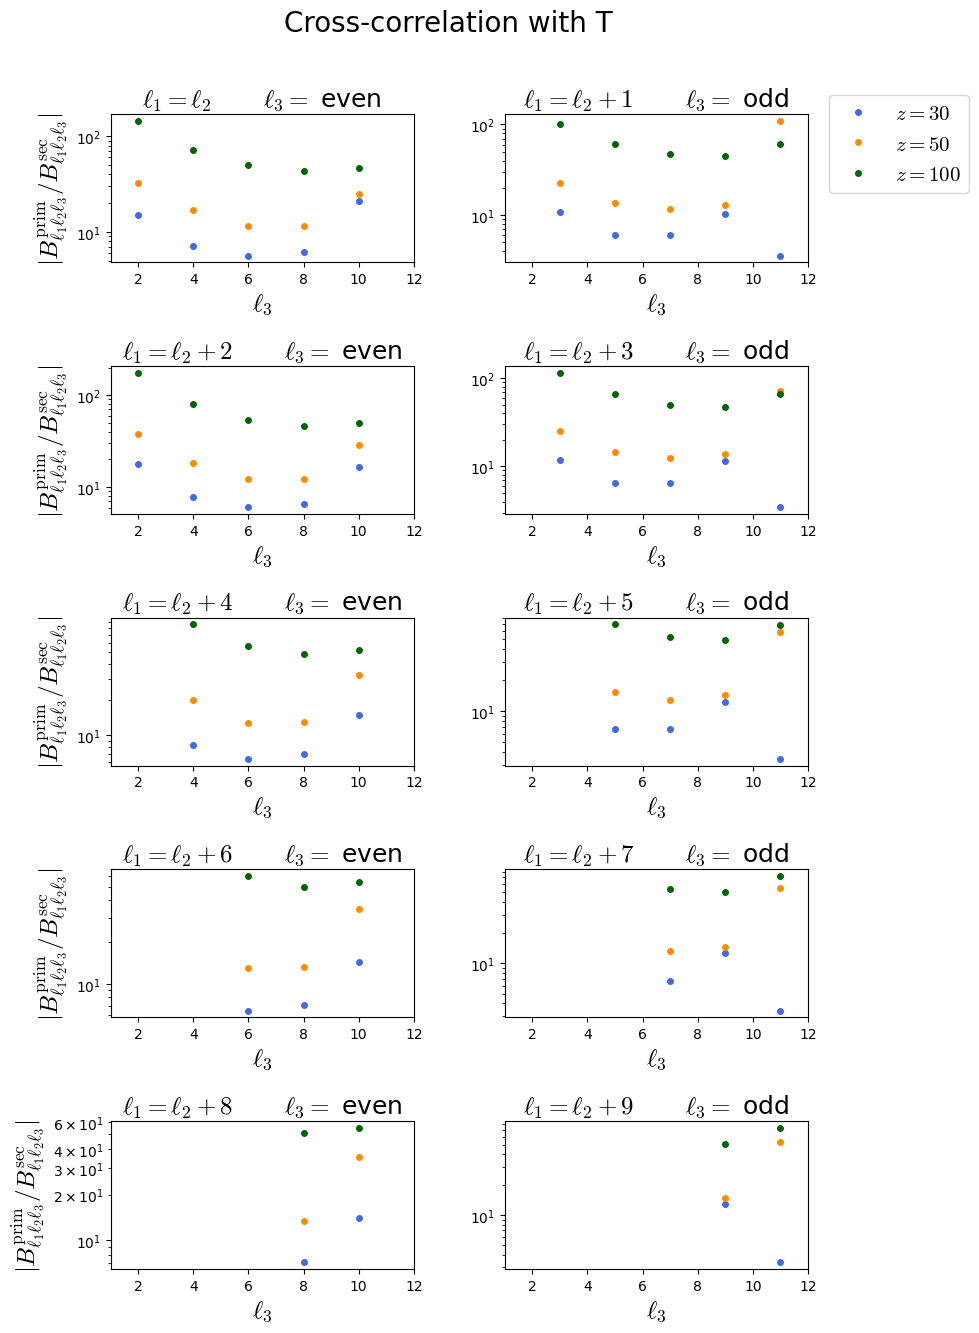

In [82]:
# plot prim/sec <21-21-T>

fig, ((ax1,ax7), (ax2,ax8), (ax3,ax9), (ax4,ax10), (ax5,ax11)) = plt.subplots(nrows=5, ncols=2, figsize=(9, 15))


fig.suptitle('Cross-correlation with T', fontsize=20,y=0.95)

fig.subplots_adjust(hspace=0.7)
fig.subplots_adjust(wspace=0.3)


ax1.set_title(r'$\ell_1 = \ell_2 \qquad$ $ \ell_3=$ even', fontsize=18)
ax2.set_title(r'$\ell_1 = \ell_2+2 \qquad$ $\ell_3=$ even', fontsize=18)
ax3.set_title(r'$\ell_1 = \ell_2+4 \qquad$ $\ell_3=$ even', fontsize=18)
ax4.set_title(r'$\ell_1 = \ell_2+6 \qquad$ $\ell_3=$ even', fontsize=18)
ax5.set_title(r'$\ell_1 = \ell_2+8 \qquad$ $\ell_3=$ even', fontsize=18)

ax7.set_title(r'$\ell_1 = \ell_2+1 \qquad$ $\ell_3=$ odd', fontsize=18)
ax8.set_title(r'$\ell_1 = \ell_2+3 \qquad$ $\ell_3=$ odd', fontsize=18)
ax9.set_title(r'$\ell_1 = \ell_2+5 \qquad$ $\ell_3=$ odd', fontsize=18)
ax10.set_title(r'$\ell_1 = \ell_2+7 \qquad$ $\ell_3=$ odd', fontsize=18)
ax11.set_title(r'$\ell_1 = \ell_2+9 \qquad$ $\ell_3=$ odd', fontsize=18)


ax1.set_xlabel(r'$\ell_3$', fontsize=18)
ax2.set_xlabel(r'$\ell_3$', fontsize=18)
ax3.set_xlabel(r'$\ell_3$', fontsize=18)
ax4.set_xlabel(r'$\ell_3$', fontsize=18)
ax5.set_xlabel(r'$\ell_3$', fontsize=18)

ax7.set_xlabel(r'$\ell_3$', fontsize=18)
ax8.set_xlabel(r'$\ell_3$', fontsize=18)
ax9.set_xlabel(r'$\ell_3$', fontsize=18)
ax10.set_xlabel(r'$\ell_3$', fontsize=18)
ax11.set_xlabel(r'$\ell_3$', fontsize=18)



ax1.set_xlim(1,12)
ax2.set_xlim(1,12)
ax3.set_xlim(1,12)
ax4.set_xlim(1,12)
ax5.set_xlim(1,12)

ax7.set_xlim(1,12)
ax8.set_xlim(1,12)
ax9.set_xlim(1,12)
ax10.set_xlim(1,12)
ax11.set_xlim(1,12)



ax1.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec}|$', fontsize=18)
ax2.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec}|$', fontsize=18)
ax3.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec}|$', fontsize=18)
ax4.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec}|$', fontsize=18)
ax5.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec}|$', fontsize=18)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')
ax5.set_yscale('log')

ax7.set_yscale('log')
ax8.set_yscale('log')
ax9.set_yscale('log')
ax10.set_yscale('log')
ax11.set_yscale('log')


ax1.plot(l3plote,np.abs(np.array(Bprim30_ll)/np.array(Bsec30_ll)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax1.plot(l3plote,np.abs(np.array(Bprim50_ll)/np.array(Bsec50_ll)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax1.plot(l3plote,np.abs(np.array(Bprim100_ll)/np.array(Bsec100_ll)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)



ax2.plot(l3plote,np.abs(np.array(Bprim30_ll2)/np.array(Bsec30_ll2)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax2.plot(l3plote,np.abs(np.array(Bprim50_ll2)/np.array(Bsec50_ll2)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax2.plot(l3plote,np.abs(np.array(Bprim100_ll2)/np.array(Bsec100_ll2)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax3.plot(l3plote[1:],np.abs(np.array(Bprim30_ll4)[1:]/np.array(Bsec30_ll4)[1:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax3.plot(l3plote[1:],np.abs(np.array(Bprim50_ll4)[1:]/np.array(Bsec50_ll4)[1:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax3.plot(l3plote[1:],np.abs(np.array(Bprim100_ll4)[1:]/np.array(Bsec100_ll4)[1:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax4.plot(l3plote[2:],np.abs(np.array(Bprim30_ll6)[2:]/np.array(Bsec30_ll6)[2:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax4.plot(l3plote[2:],np.abs(np.array(Bprim50_ll6)[2:]/np.array(Bsec50_ll6)[2:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax4.plot(l3plote[2:],np.abs(np.array(Bprim100_ll6)[2:]/np.array(Bsec100_ll6)[2:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax5.plot(l3plote[3:],np.abs(np.array(Bprim30_ll8)[3:]/np.array(Bsec30_ll8)[3:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax5.plot(l3plote[3:],np.abs(np.array(Bprim50_ll8)[3:]/np.array(Bsec50_ll8)[3:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax5.plot(l3plote[3:],np.abs(np.array(Bprim100_ll8)[3:]/np.array(Bsec100_ll8)[3:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)




ax7.plot(l3ploto,np.abs(np.array(Bprim30_ll1)/np.array(Bsec30_ll1)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax7.plot(l3ploto,np.abs(np.array(Bprim50_ll1)/np.array(Bsec50_ll1)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax7.plot(l3ploto,np.abs(np.array(Bprim100_ll1)/np.array(Bsec100_ll1)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax7.legend(bbox_to_anchor=(1.3, 0.80), loc='center', ncol = 1, borderaxespad=0., fontsize=15)#(loc='best', fontsize=20)



ax8.plot(l3ploto,np.abs(np.array(Bprim30_ll3)/np.array(Bsec30_ll3)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax8.plot(l3ploto,np.abs(np.array(Bprim50_ll3)/np.array(Bsec50_ll3)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax8.plot(l3ploto,np.abs(np.array(Bprim100_ll3)/np.array(Bsec100_ll3)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax9.plot(l3ploto[1:],np.abs(np.array(Bprim30_ll5)[1:]/np.array(Bsec30_ll5)[1:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax9.plot(l3ploto[1:],np.abs(np.array(Bprim50_ll5)[1:]/np.array(Bsec50_ll5)[1:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax9.plot(l3ploto[1:],np.abs(np.array(Bprim100_ll5)[1:]/np.array(Bsec100_ll5)[1:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax10.plot(l3ploto[2:],np.abs(np.array(Bprim30_ll7)[2:]/np.array(Bsec30_ll7)[2:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax10.plot(l3ploto[2:],np.abs(np.array(Bprim50_ll7)[2:]/np.array(Bsec50_ll7)[2:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax10.plot(l3ploto[2:],np.abs(np.array(Bprim100_ll7)[2:]/np.array(Bsec100_ll7)[2:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax11.plot(l3ploto[3:],np.abs(np.array(Bprim30_ll9)[3:]/np.array(Bsec30_ll9)[3:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax11.plot(l3ploto[3:],np.abs(np.array(Bprim50_ll9)[3:]/np.array(Bsec50_ll9)[3:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax11.plot(l3ploto[3:],np.abs(np.array(Bprim100_ll9)[3:]/np.array(Bsec100_ll9)[3:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


plt.savefig("plots/prims_vs_sec.pdf", dpi=300, bbox_inches='tight')


plt.show()
plt.close()

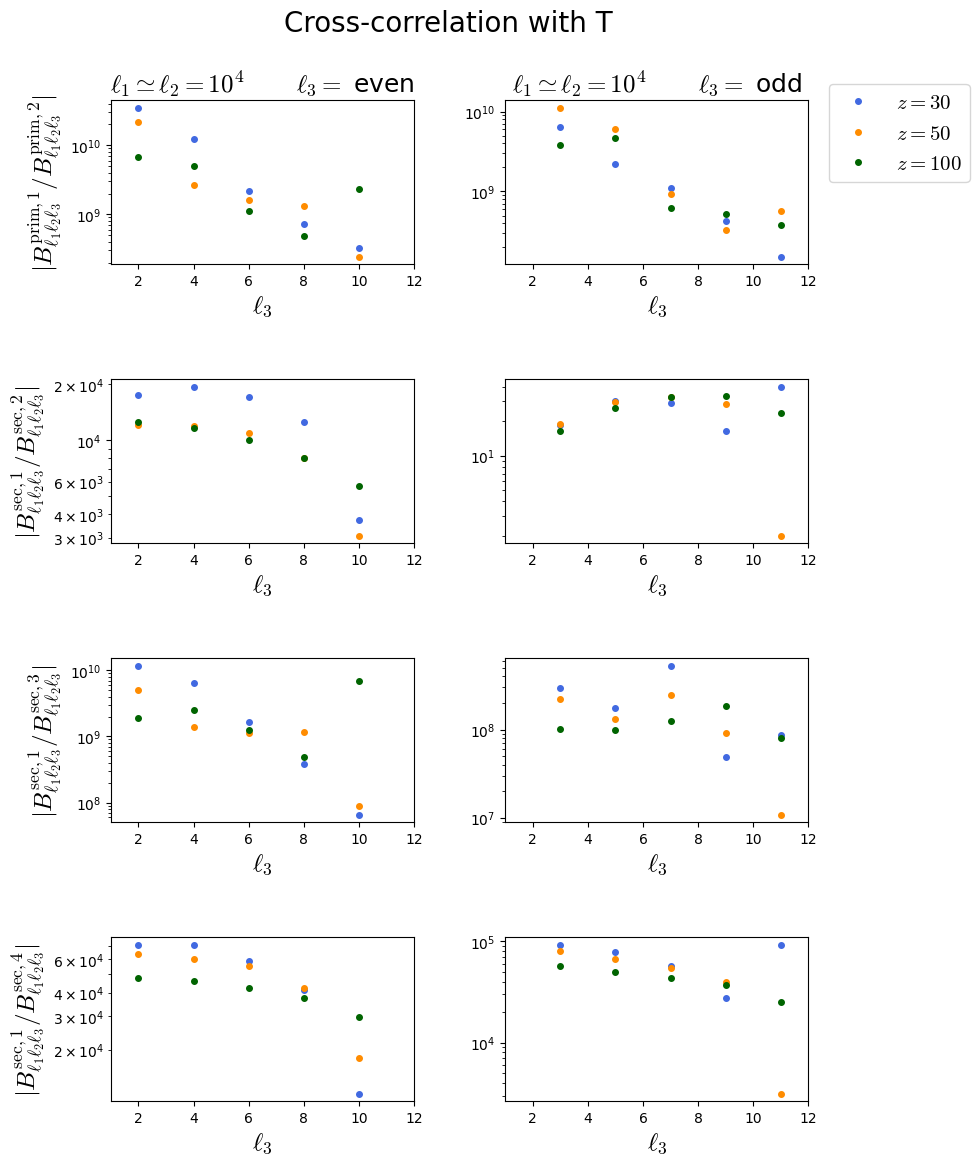

In [83]:
# plot prim1/otherprim and sec1/othersec, <21-21-T>

fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(nrows=4, ncols=2, figsize=(9, 13))



fig.suptitle('Cross-correlation with T', fontsize=20,y=0.95)




fig.subplots_adjust(hspace=0.7)
fig.subplots_adjust(wspace=0.3)


ax1.set_title(r'$\ell_1 \simeq \ell_2 = 10^4 \qquad$ $ \ell_3=$ even', fontsize=18)
ax2.set_title(r'$\ell_1 \simeq \ell_2 = 10^4 \qquad$ $ \ell_3=$ odd', fontsize=18)



ax1.set_xlabel(r'$\ell_3$', fontsize=18)
ax2.set_xlabel(r'$\ell_3$', fontsize=18)

ax3.set_xlabel(r'$\ell_3$', fontsize=18)
ax4.set_xlabel(r'$\ell_3$', fontsize=18)

ax5.set_xlabel(r'$\ell_3$', fontsize=18)
ax6.set_xlabel(r'$\ell_3$', fontsize=18)

ax7.set_xlabel(r'$\ell_3$', fontsize=18)
ax8.set_xlabel(r'$\ell_3$', fontsize=18)





ax1.set_xlim(1,12)
ax2.set_xlim(1,12)
ax3.set_xlim(1,12)
ax4.set_xlim(1,12)
ax5.set_xlim(1,12)
ax6.set_xlim(1,12)
ax7.set_xlim(1,12)
ax8.set_xlim(1,12)




ax1.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim, 1}/B_{\ell_1 \ell_2 \ell_3}^{\rm prim, 2}|$', fontsize=18)


ax3.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 1}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 2}|$', fontsize=18)


ax5.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 1}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 3}|$', fontsize=18)


ax7.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 1}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 4}|$', fontsize=18)



ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')
ax5.set_yscale('log')
ax6.set_yscale('log')
ax7.set_yscale('log')
ax8.set_yscale('log')

ax1.plot(l3plote,np.abs(np.array(Bprim30_ll)/np.array(Bprim230_ll)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax1.plot(l3plote,np.abs(np.array(Bprim50_ll)/np.array(Bprim250_ll)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax1.plot(l3plote,np.abs(np.array(Bprim100_ll)/np.array(Bprim2100_ll)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax2.plot(l3ploto,np.abs(np.array(Bprim30_ll1)/np.array(Bprim230_ll1)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax2.plot(l3ploto,np.abs(np.array(Bprim50_ll1)/np.array(Bprim250_ll1)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax2.plot(l3ploto,np.abs(np.array(Bprim100_ll1)/np.array(Bprim2100_ll1)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax2.legend(bbox_to_anchor=(1.3, 0.80), loc='center', ncol = 1, borderaxespad=0., fontsize=15)#(loc='best', fontsize=20)


ax3.plot(l3plote,np.abs(np.array(Bsec130_ll)/np.array(Bsec230_ll)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax3.plot(l3plote,np.abs(np.array(Bsec150_ll)/np.array(Bsec250_ll)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax3.plot(l3plote,np.abs(np.array(Bsec1100_ll)/np.array(Bsec2100_ll)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax4.plot(l3ploto,np.abs(np.array(Bsec130_ll1)/np.array(Bsec230_ll1)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax4.plot(l3ploto,np.abs(np.array(Bsec150_ll1)/np.array(Bsec250_ll1)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax4.plot(l3ploto,np.abs(np.array(Bsec1100_ll1)/np.array(Bsec2100_ll1)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax5.plot(l3plote,np.abs(np.array(Bsec130_ll)/np.array(Bsec330_ll)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax5.plot(l3plote,np.abs(np.array(Bsec150_ll)/np.array(Bsec350_ll)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax5.plot(l3plote,np.abs(np.array(Bsec1100_ll)/np.array(Bsec3100_ll)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax6.plot(l3ploto,np.abs(np.array(Bsec130_ll1)/np.array(Bsec330_ll1)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax6.plot(l3ploto,np.abs(np.array(Bsec150_ll1)/np.array(Bsec350_ll1)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax6.plot(l3ploto,np.abs(np.array(Bsec1100_ll1)/np.array(Bsec3100_ll1)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax7.plot(l3plote,np.abs(np.array(Bsec130_ll)/np.array(Bsec430_ll)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax7.plot(l3plote,np.abs(np.array(Bsec150_ll)/np.array(Bsec450_ll)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax7.plot(l3plote,np.abs(np.array(Bsec1100_ll)/np.array(Bsec4100_ll)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax8.plot(l3ploto,np.abs(np.array(Bsec130_ll1)/np.array(Bsec430_ll1)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax8.plot(l3ploto,np.abs(np.array(Bsec150_ll1)/np.array(Bsec450_ll1)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax8.plot(l3ploto,np.abs(np.array(Bsec1100_ll1)/np.array(Bsec4100_ll1)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

plt.savefig("plots/match_terms_T.pdf", dpi=300, bbox_inches='tight')


plt.show()
plt.close()

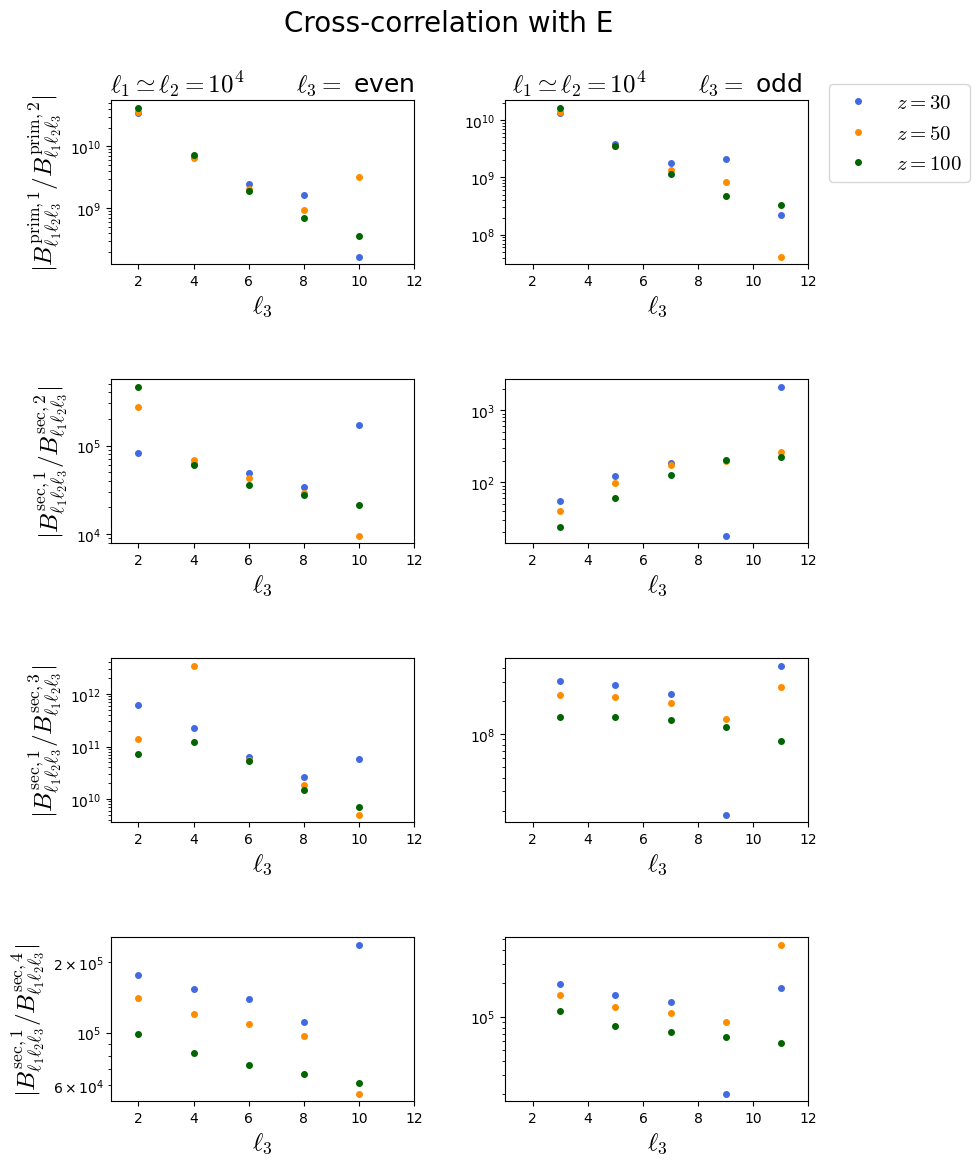

In [84]:
# plot prim1/otherprim sec1/othersec <21-21-E>

fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(nrows=4, ncols=2, figsize=(9, 13))


fig.suptitle('Cross-correlation with E', fontsize=20,y=0.95)




fig.subplots_adjust(hspace=0.7)
fig.subplots_adjust(wspace=0.3)


ax1.set_title(r'$\ell_1 \simeq \ell_2 = 10^4 \qquad$ $ \ell_3=$ even', fontsize=18)
ax2.set_title(r'$\ell_1 \simeq \ell_2 = 10^4 \qquad$ $ \ell_3=$ odd', fontsize=18)



ax1.set_xlabel(r'$\ell_3$', fontsize=18)
ax2.set_xlabel(r'$\ell_3$', fontsize=18)

ax3.set_xlabel(r'$\ell_3$', fontsize=18)
ax4.set_xlabel(r'$\ell_3$', fontsize=18)

ax5.set_xlabel(r'$\ell_3$', fontsize=18)
ax6.set_xlabel(r'$\ell_3$', fontsize=18)

ax7.set_xlabel(r'$\ell_3$', fontsize=18)
ax8.set_xlabel(r'$\ell_3$', fontsize=18)





ax1.set_xlim(1,12)
ax2.set_xlim(1,12)
ax3.set_xlim(1,12)
ax4.set_xlim(1,12)
ax5.set_xlim(1,12)
ax6.set_xlim(1,12)
ax7.set_xlim(1,12)
ax8.set_xlim(1,12)




ax1.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim, 1}/B_{\ell_1 \ell_2 \ell_3}^{\rm prim, 2}|$', fontsize=18)


ax3.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 1}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 2}|$', fontsize=18)


ax5.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 1}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 3}|$', fontsize=18)


ax7.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 1}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 4}|$', fontsize=18)



ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')
ax5.set_yscale('log')
ax6.set_yscale('log')
ax7.set_yscale('log')
ax8.set_yscale('log')

ax1.plot(l3plote,np.abs(np.array(Bprim30pol_ll)/np.array(Bprim230pol_ll)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax1.plot(l3plote,np.abs(np.array(Bprim50pol_ll)/np.array(Bprim250pol_ll)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax1.plot(l3plote,np.abs(np.array(Bprim100pol_ll)/np.array(Bprim2100pol_ll)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax2.plot(l3ploto,np.abs(np.array(Bprim30pol_ll1)/np.array(Bprim230pol_ll1)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax2.plot(l3ploto,np.abs(np.array(Bprim50pol_ll1)/np.array(Bprim250pol_ll1)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax2.plot(l3ploto,np.abs(np.array(Bprim100pol_ll1)/np.array(Bprim2100pol_ll1)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax2.legend(bbox_to_anchor=(1.3, 0.80), loc='center', ncol = 1, borderaxespad=0., fontsize=15)#(loc='best', fontsize=20)


ax3.plot(l3plote,np.abs(np.array(Bsec130pol_ll)/np.array(Bsec230pol_ll)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax3.plot(l3plote,np.abs(np.array(Bsec150pol_ll)/np.array(Bsec250pol_ll)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax3.plot(l3plote,np.abs(np.array(Bsec1100pol_ll)/np.array(Bsec2100pol_ll)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax4.plot(l3ploto,np.abs(np.array(Bsec130pol_ll1)/np.array(Bsec230pol_ll1)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax4.plot(l3ploto,np.abs(np.array(Bsec150pol_ll1)/np.array(Bsec250pol_ll1)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax4.plot(l3ploto,np.abs(np.array(Bsec1100pol_ll1)/np.array(Bsec2100pol_ll1)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax5.plot(l3plote,np.abs(np.array(Bsec130pol_ll)/np.array(Bsec330pol_ll)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax5.plot(l3plote,np.abs(np.array(Bsec150pol_ll)/np.array(Bsec350pol_ll)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax5.plot(l3plote,np.abs(np.array(Bsec1100pol_ll)/np.array(Bsec3100pol_ll)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax6.plot(l3ploto,np.abs(np.array(Bsec130pol_ll1)/np.array(Bsec330pol_ll1)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax6.plot(l3ploto,np.abs(np.array(Bsec150pol_ll1)/np.array(Bsec350pol_ll1)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax6.plot(l3ploto,np.abs(np.array(Bsec1100pol_ll1)/np.array(Bsec3100pol_ll1)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax7.plot(l3plote,np.abs(np.array(Bsec130pol_ll)/np.array(Bsec430pol_ll)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax7.plot(l3plote,np.abs(np.array(Bsec150pol_ll)/np.array(Bsec450pol_ll)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax7.plot(l3plote,np.abs(np.array(Bsec1100pol_ll)/np.array(Bsec4100pol_ll)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax8.plot(l3ploto,np.abs(np.array(Bsec130pol_ll1)/np.array(Bsec430pol_ll1)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax8.plot(l3ploto,np.abs(np.array(Bsec150pol_ll1)/np.array(Bsec450pol_ll1)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax8.plot(l3ploto,np.abs(np.array(Bsec1100pol_ll1)/np.array(Bsec4100pol_ll1)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)






plt.savefig("plots/match_terms_E.pdf", dpi=300, bbox_inches='tight')


plt.show()
plt.close()

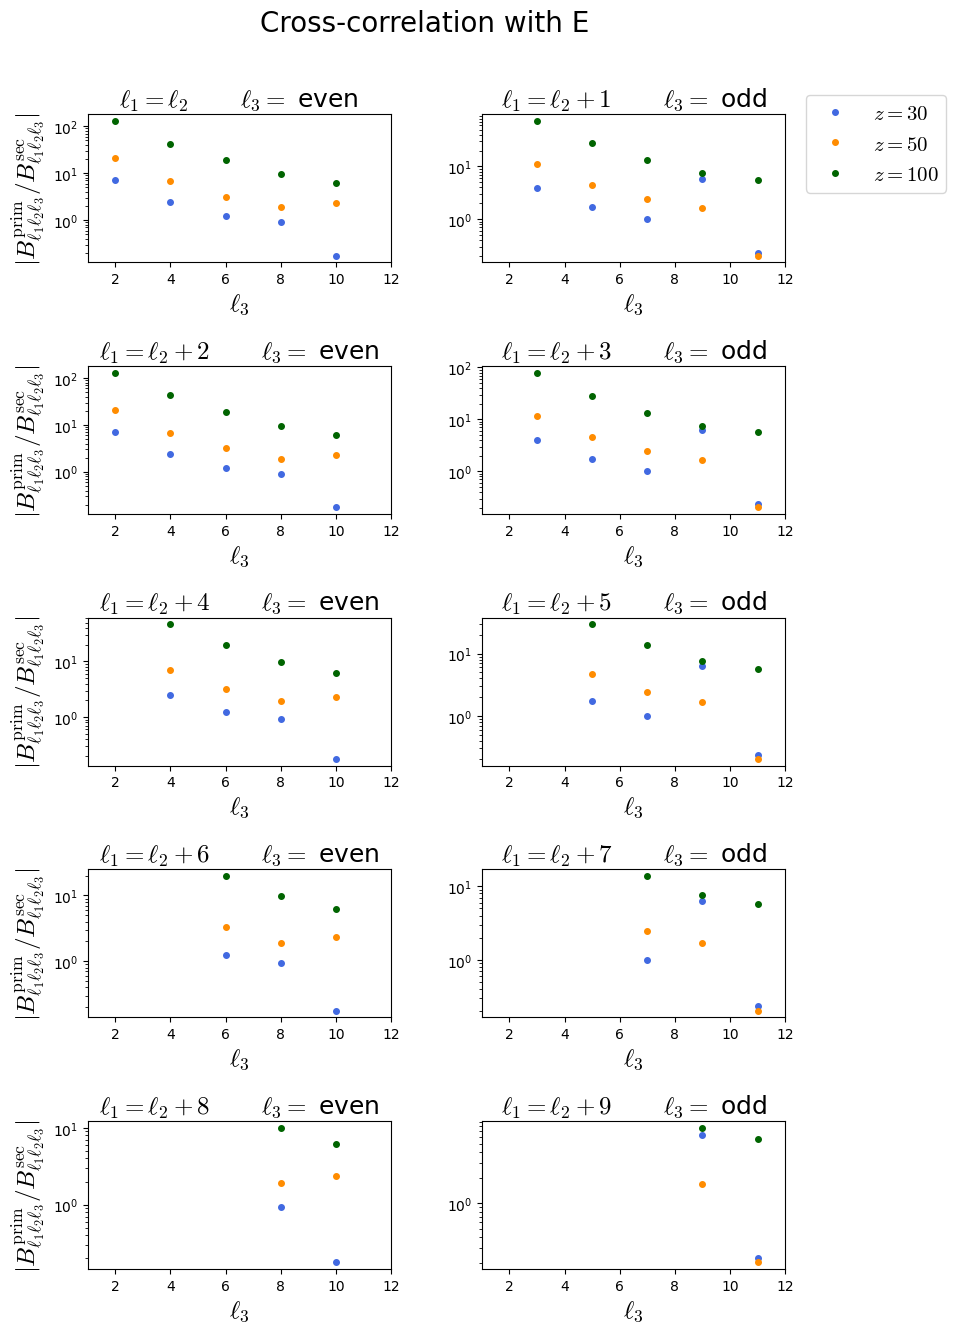

In [85]:
# plot prim/sec <21-21-E>

fig, ((ax1,ax7), (ax2,ax8), (ax3,ax9), (ax4,ax10), (ax5,ax11)) = plt.subplots(nrows=5, ncols=2, figsize=(9, 15))


fig.suptitle('Cross-correlation with E', fontsize=20,y=0.95)




fig.subplots_adjust(hspace=0.7)
fig.subplots_adjust(wspace=0.3)


ax1.set_title(r'$\ell_1 = \ell_2 \qquad$ $\ell_3=$ even', fontsize=18)
ax2.set_title(r'$\ell_1 = \ell_2+2 \qquad$ $\ell_3=$ even', fontsize=18)
ax3.set_title(r'$\ell_1 = \ell_2+4 \qquad$ $\ell_3=$ even', fontsize=18)
ax4.set_title(r'$\ell_1 = \ell_2+6 \qquad$ $\ell_3=$ even', fontsize=18)
ax5.set_title(r'$\ell_1 = \ell_2+8 \qquad$ $\ell_3=$ even', fontsize=18)

ax7.set_title(r'$\ell_1 = \ell_2+1 \qquad$ $\ell_3=$ odd', fontsize=18)
ax8.set_title(r'$\ell_1 = \ell_2+3 \qquad$ $\ell_3=$ odd', fontsize=18)
ax9.set_title(r'$\ell_1 = \ell_2+5 \qquad$ $\ell_3=$ odd', fontsize=18)
ax10.set_title(r'$\ell_1 = \ell_2+7 \qquad$ $\ell_3=$ odd', fontsize=18)
ax11.set_title(r'$\ell_1 = \ell_2+9 \qquad$ $\ell_3=$ odd', fontsize=18)


ax1.set_xlabel(r'$\ell_3$', fontsize=18)
ax2.set_xlabel(r'$\ell_3$', fontsize=18)
ax3.set_xlabel(r'$\ell_3$', fontsize=18)
ax4.set_xlabel(r'$\ell_3$', fontsize=18)
ax5.set_xlabel(r'$\ell_3$', fontsize=18)

ax7.set_xlabel(r'$\ell_3$', fontsize=18)
ax8.set_xlabel(r'$\ell_3$', fontsize=18)
ax9.set_xlabel(r'$\ell_3$', fontsize=18)
ax10.set_xlabel(r'$\ell_3$', fontsize=18)
ax11.set_xlabel(r'$\ell_3$', fontsize=18)



ax1.set_xlim(1,12)
ax2.set_xlim(1,12)
ax3.set_xlim(1,12)
ax4.set_xlim(1,12)
ax5.set_xlim(1,12)

ax7.set_xlim(1,12)
ax8.set_xlim(1,12)
ax9.set_xlim(1,12)
ax10.set_xlim(1,12)
ax11.set_xlim(1,12)



ax1.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec}|$', fontsize=18)
ax2.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec}|$', fontsize=18)
ax3.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec}|$', fontsize=18)
ax4.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec}|$', fontsize=18)
ax5.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec}|$', fontsize=18)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')
ax5.set_yscale('log')

ax7.set_yscale('log')
ax8.set_yscale('log')
ax9.set_yscale('log')
ax10.set_yscale('log')
ax11.set_yscale('log')


ax1.plot(l3plote,np.abs(np.array(Bprim30pol_ll)/np.array(Bsec30pol_ll)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax1.plot(l3plote,np.abs(np.array(Bprim50pol_ll)/np.array(Bsec50pol_ll)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax1.plot(l3plote,np.abs(np.array(Bprim100pol_ll)/np.array(Bsec100pol_ll)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)



ax2.plot(l3plote,np.abs(np.array(Bprim30pol_ll2)/np.array(Bsec30pol_ll2)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax2.plot(l3plote,np.abs(np.array(Bprim50pol_ll2)/np.array(Bsec50pol_ll2)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax2.plot(l3plote,np.abs(np.array(Bprim100pol_ll2)/np.array(Bsec100pol_ll2)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax3.plot(l3plote[1:],np.abs(np.array(Bprim30pol_ll4)[1:]/np.array(Bsec30pol_ll4)[1:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax3.plot(l3plote[1:],np.abs(np.array(Bprim50pol_ll4)[1:]/np.array(Bsec50pol_ll4)[1:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax3.plot(l3plote[1:],np.abs(np.array(Bprim100pol_ll4)[1:]/np.array(Bsec100pol_ll4)[1:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax4.plot(l3plote[2:],np.abs(np.array(Bprim30pol_ll6)[2:]/np.array(Bsec30pol_ll6)[2:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax4.plot(l3plote[2:],np.abs(np.array(Bprim50pol_ll6)[2:]/np.array(Bsec50pol_ll6)[2:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax4.plot(l3plote[2:],np.abs(np.array(Bprim100pol_ll6)[2:]/np.array(Bsec100pol_ll6)[2:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax5.plot(l3plote[3:],np.abs(np.array(Bprim30pol_ll8)[3:]/np.array(Bsec30pol_ll8)[3:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax5.plot(l3plote[3:],np.abs(np.array(Bprim50pol_ll8)[3:]/np.array(Bsec50pol_ll8)[3:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax5.plot(l3plote[3:],np.abs(np.array(Bprim100pol_ll8)[3:]/np.array(Bsec100pol_ll8)[3:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)




ax7.plot(l3ploto,np.abs(np.array(Bprim30pol_ll1)/np.array(Bsec30pol_ll1)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax7.plot(l3ploto,np.abs(np.array(Bprim50pol_ll1)/np.array(Bsec50pol_ll1)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax7.plot(l3ploto,np.abs(np.array(Bprim100pol_ll1)/np.array(Bsec100pol_ll1)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax7.legend(bbox_to_anchor=(1.3, 0.80), loc='center', ncol = 1, borderaxespad=0., fontsize=15)#(loc='best', fontsize=20)



ax8.plot(l3ploto,np.abs(np.array(Bprim30pol_ll3)/np.array(Bsec30pol_ll3)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax8.plot(l3ploto,np.abs(np.array(Bprim50pol_ll3)/np.array(Bsec50pol_ll3)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax8.plot(l3ploto,np.abs(np.array(Bprim100pol_ll3)/np.array(Bsec100pol_ll3)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax9.plot(l3ploto[1:],np.abs(np.array(Bprim30pol_ll5)[1:]/np.array(Bsec30pol_ll5)[1:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax9.plot(l3ploto[1:],np.abs(np.array(Bprim50pol_ll5)[1:]/np.array(Bsec50pol_ll5)[1:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax9.plot(l3ploto[1:],np.abs(np.array(Bprim100pol_ll5)[1:]/np.array(Bsec100pol_ll5)[1:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax10.plot(l3ploto[2:],np.abs(np.array(Bprim30pol_ll7)[2:]/np.array(Bsec30pol_ll7)[2:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax10.plot(l3ploto[2:],np.abs(np.array(Bprim50pol_ll7)[2:]/np.array(Bsec50pol_ll7)[2:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax10.plot(l3ploto[2:],np.abs(np.array(Bprim100pol_ll7)[2:]/np.array(Bsec100pol_ll7)[2:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax11.plot(l3ploto[3:],np.abs(np.array(Bprim30pol_ll9)[3:]/np.array(Bsec30pol_ll9)[3:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax11.plot(l3ploto[3:],np.abs(np.array(Bprim50pol_ll9)[3:]/np.array(Bsec50pol_ll9)[3:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax11.plot(l3ploto[3:],np.abs(np.array(Bprim100pol_ll9)[3:]/np.array(Bsec100pol_ll9)[3:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


plt.savefig("plots/prims_vs_secpol.pdf", dpi=300, bbox_inches='tight')


plt.show()
plt.close()

## PS, flat-sky exact vs full-sky Limber

In [86]:
# list of l for plot

llistpl = np.logspace(3,5,100)

def trans(qpar,l,r,z):
    if z==30:
        alpha = alp1r(r30)
        T = t21r(r30)
    elif z==50:
        alpha = alp1r(r50)
        T = t21r(r50)
    elif z==100:
        alpha = alp1r(r100)
        T = t21r(r100)
    value = (alpha + T*qpar**2/(qpar**2+l**2/r**2))
    return value

def trans_novel(qpar,l,r,z):
    if z==30:
        alpha = alp1r(r30)
        T = t21r(r30)
    elif z==50:
        alpha = alp1r(r50)
        T = t21r(r50)
    elif z==100:
        alpha = alp1r(r100)
        T = t21r(r100)
    value = (alpha)
    return value

In [88]:
# 21-cm PS exact flat sky

def c21(i,r,z,dnu):
    l= int(llistpl[i])
    
    if z == 30:
        integrand = lambda q: Wq(q,z,dnu)**2*trans(q,l,r,z)**2*(mono30f(np.sqrt(q**2+l**2/r**2)))**2*scalarpower(np.sqrt(q**2+l**2/r**2))
    elif z == 50:
        integrand = lambda q: Wq(q,z,dnu)**2*trans(q,l,r,z)**2*(mono50f(np.sqrt(q**2+l**2/r**2)))**2*scalarpower(np.sqrt(q**2+l**2/r**2))
    elif z == 100:
        integrand = lambda q: Wq(q,z,dnu)**2*trans(q,l,r,z)**2*(mono100f(np.sqrt(q**2+l**2/r**2)))**2*scalarpower(np.sqrt(q**2+l**2/r**2))
    
    inte = scint.quad(integrand,1e-5,200.,epsabs=0.,epsrel=1e-4, limit = 10000000)[0]
    factor = l**2/(2*np.pi)
    value = inte*factor/r**2/(2*np.pi)
    return value

def c21_novel(i,r,z,dnu):
    l= int(llistpl[i])
    
    if z == 30:
        integrand = lambda q: Wq(q,z,dnu)**2*trans_novel(q,l,r,z)**2*(mono30f(np.sqrt(q**2+l**2/r**2)))**2*scalarpower(np.sqrt(q**2+l**2/r**2))
    elif z == 50:
        integrand = lambda q: Wq(q,z,dnu)**2*trans_novel(q,l,r,z)**2*(mono50f(np.sqrt(q**2+l**2/r**2)))**2*scalarpower(np.sqrt(q**2+l**2/r**2))
    elif z == 100:
        integrand = lambda q: Wq(q,z,dnu)**2*trans_novel(q,l,r,z)**2*(mono100f(np.sqrt(q**2+l**2/r**2)))**2*scalarpower(np.sqrt(q**2+l**2/r**2))
    
    inte = scint.quad(integrand,1e-5,200.,epsabs=0.,epsrel=1e-4, limit = 10000000)[0]
    factor = l**2/(2*np.pi)
    value = inte*factor/r**2/(2*np.pi)
    return value

c21(0,r100,100.,1.), c21_novel(0,r100,100.,1.)

(0.008772282775900616, 0.007245598914095965)

In [93]:
# y-sampling for 21-cm PS computation- full sky Limber 

def Limber21_c21_30(l):
    value = np.array([yp*W(r30,yp,30,0.1)**2*mono30f(l/yp)**2*alp1r(yp)**2*scal_pow(l/yp) for yp in y30])
    return value   

def Limber21_c21_50(l):
    value = np.array([yp*W(r50,yp,50,0.1)**2*mono50f(l/yp)**2*alp1r(yp)**2*scal_pow(l/yp) for yp in y50])
    return value   

def Limber21_c21_100(l):
    value = np.array([yp*W(r100,yp,100,0.1)**2*mono100f(l/yp)**2*alp1r(yp)**2*scal_pow(l/yp) for yp in y100])
    return value   

# y-sampling for 21-cm PS computation- full sky Limber - Deltaw = 1 MHz case  

def Limber21_c21_30_1Mhz(l):
    value = np.array([yp*W(r30,yp,30,1)**2*mono30f(l/yp)**2*alp1r(yp)**2*scal_pow(l/yp) for yp in y301])
    return value   

def Limber21_c21_50_1Mhz(l):
    value = np.array([yp*W(r50,yp,50,1)**2*mono50f(l/yp)**2*alp1r(yp)**2*scal_pow(l/yp) for yp in y501])
    return value   

def Limber21_c21_100_1Mhz(l):
    value = np.array([yp*W(r100,yp,100,1)**2*mono100f(l/yp)**2*alp1r(yp)**2*scal_pow(l/yp) for yp in y1001])
    return value 

In [94]:
# 21-cm PS, limber+no velocity terms, for Fisher forecasts

def c21_30(i,r,z,dnu):
    l= int(llist2[i])
    cms = Limber21_c21_30(l)
    I2= integrate.simps(cms,x=y30, even='avg')
    factor = 2*np.pi**2/l**3
    value = I2*factor
    return value

def c21_50(i,r,z,dnu):
    l= int(llist2[i])
    cms = Limber21_c21_50(l)
    I2= integrate.simps(cms,x=y50, even='avg')
    factor = 2*np.pi**2/l**3
    value = I2*factor
    return value

def c21_100(i,r,z,dnu):
    l= int(llist2[i])
    cms = Limber21_c21_100(l)
    I2= integrate.simps(cms,x=y100, even='avg')
    factor = 2*np.pi**2/l**3
    value = I2*factor
    return value

In [95]:
# 21-cm PS, limber+no velocity terms for plot

def c21_30plt(i,r,z,dnu):
    l= int(llistpl[i])
    cms = Limber21_c21_30(l)
    I2= integrate.simps(cms,x=y30, even='avg')
    factor = 2*np.pi**2/l**3
    value = I2*factor
    return value

def c21_50plt(i,r,z,dnu):
    l= int(llistpl[i])
    cms = Limber21_c21_50(l)
    I2= integrate.simps(cms,x=y50, even='avg')
    factor = 2*np.pi**2/l**3
    value = I2*factor
    return value

def c21_100plt(i,r,z,dnu):
    l= int(llistpl[i])
    cms = Limber21_c21_100(l)
    I2= integrate.simps(cms,x=y100, even='avg')
    factor = 2*np.pi**2/l**3
    value = I2*factor
    return value


# 21-cm PS, limber+no velocity terms for plot - Deltaw = 1 MHz case 

def c21_30plt1(i,r,z,dnu):
    l= int(llistpl[i])
    cms = Limber21_c21_30_1Mhz(l)
    I2= integrate.simps(cms,x=y301, even='avg')
    factor = 2*np.pi**2/l**3
    value = I2*factor
    return value

def c21_50plt1(i,r,z,dnu):
    l= int(llistpl[i])
    cms = Limber21_c21_50_1Mhz(l)
    I2= integrate.simps(cms,x=y501, even='avg')
    factor = 2*np.pi**2/l**3
    value = I2*factor
    return value

def c21_100plt1(i,r,z,dnu):
    l= int(llistpl[i])
    cms = Limber21_c21_100_1Mhz(l)
    I2= integrate.simps(cms,x=y1001, even='avg')
    factor = 2*np.pi**2/l**3
    value = I2*factor
    return value

In [97]:
# 21-cm PS computation, limber+no vel z=30, for Fisher-Forecast

C21r30w01=np.array([c21_30(i,r30,30,0.1) for i in range(len(llist2))])

In [98]:
# 21-cm PS computation, limber+no vel z=50, for Fisher-Forecast
C21r50w01=np.array([c21_50(i,r50,50,0.1) for i in range(len(llist2))])

In [99]:
# 21-cm PS computation, limber+no vel z=100, for Fisher-Forecast

C21r100w01=np.array([c21_100(i,r100,100,0.1) for i in range(len(llist2))])

In [100]:
# SAVE RESULTS

C21rawr30w01 = np.array([llist2, C21r30w01]).T
# np.savetxt('C21rawr30w01.txt', C21rawr30w01)

C21rawr50w01 = np.array([llist2, C21r50w01]).T
# np.savetxt('C21rawr50w01.txt', C21rawr50w01)

C21rawr100w01 = np.array([llist2, C21r100w01]).T
# np.savetxt('C21rawr100w01.txt', C21rawr100w01)

In [101]:
# 21-cm PS Limber Delta_nu = 0.1 

C21r30w01plt=[np.sqrt(c21_30plt(i,r30,30,0.1)*llistpl[i]**2/(2*np.pi)) for i in range(len(llistpl))]
C21r50w01plt=[np.sqrt(c21_50plt(i,r50,50,0.1)*llistpl[i]**2/(2*np.pi)) for i in range(len(llistpl))]
C21r100w01plt=[np.sqrt(c21_100plt(i,r100,100,0.1)*llistpl[i]**2/(2*np.pi)) for i in range(len(llistpl))]

In [102]:
# 21-cm PS Limber Delta_nu = 1 

C21r30w1plt=[np.sqrt(c21_30plt1(i,r30,30,1)*llistpl[i]**2/(2*np.pi)) for i in range(len(llistpl))]
C21r50w1plt=[np.sqrt(c21_50plt1(i,r50,50,1)*llistpl[i]**2/(2*np.pi)) for i in range(len(llistpl))]
C21r100w1plt=[np.sqrt(c21_100plt1(i,r100,100,1)*llistpl[i]**2/(2*np.pi)) for i in range(len(llistpl))]

In [103]:
# 21-cm PS exact z = 30

C21r3001=[np.sqrt(c21(i,r30,30.,0.1)) for i in range(len(llistpl))]
C21r301=[np.sqrt(c21(i,r30,30.,1.)) for i in range(len(llistpl))]
C21r300=[np.sqrt(c21(i,r30,30.,0.)) for i in range(len(llistpl))]

C21r3001_novel=[np.sqrt(c21_novel(i,r30,30.,0.1)) for i in range(len(llistpl))]
C21r301_novel=[np.sqrt(c21_novel(i,r30,30.,1.)) for i in range(len(llistpl))]
C21r300_novel=[np.sqrt(c21_novel(i,r30,30.,0.)) for i in range(len(llistpl))]

In [104]:
# 21-cm PS exact z = 50

C21r5001=[np.sqrt(c21(i,r50,50.,0.1)) for i in range(len(llistpl))]
C21r501=[np.sqrt(c21(i,r50,50.,1.)) for i in range(len(llistpl))]
C21r500=[np.sqrt(c21(i,r50,50.,0.)) for i in range(len(llistpl))]


C21r5001_novel=[np.sqrt(c21_novel(i,r50,50.,0.1)) for i in range(len(llistpl))]
C21r501_novel=[np.sqrt(c21_novel(i,r50,50.,1.)) for i in range(len(llistpl))]
C21r500_novel=[np.sqrt(c21_novel(i,r50,50.,0.)) for i in range(len(llistpl))]

In [105]:
# 21-cm PS exact z = 100

C21r10001=[np.sqrt(c21(i,r100,100.,0.1)) for i in range(len(llistpl))]
C21r1001=[np.sqrt(c21(i,r100,100.,1.)) for i in range(len(llistpl))]
C21r1000=[np.sqrt(c21(i,r100,100.,0.)) for i in range(len(llistpl))]

C21r10001_novel=[np.sqrt(c21_novel(i,r100,100.,0.1)) for i in range(len(llistpl))]
C21r1001_novel=[np.sqrt(c21_novel(i,r100,100.,1.)) for i in range(len(llistpl))]
C21r1000_novel=[np.sqrt(c21_novel(i,r100,100.,0.)) for i in range(len(llistpl))]

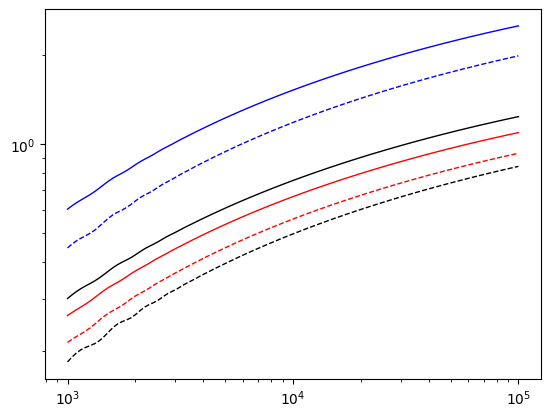

In [106]:
plt.loglog(llistpl,C21r500, label = '$z=30$', color = 'blue', linewidth = 1, linestyle = '-', zorder = 10)
plt.loglog(llistpl,C21r300, label = '$z=30$', color = 'red', linewidth = 1, linestyle = '-', zorder = 10)
plt.loglog(llistpl,C21r1000, label = '$z=30$', color = 'black', linewidth = 1, linestyle = '-', zorder = 10)

plt.loglog(llistpl,C21r500_novel, label = '$z=30$', color = 'blue', linewidth = 1, linestyle = '--', zorder = 10)
plt.loglog(llistpl,C21r300_novel, label = '$z=30$', color = 'red', linewidth = 1, linestyle = '--', zorder = 10)
plt.loglog(llistpl,C21r1000_novel, label = '$z=30$', color = 'black', linewidth = 1, linestyle = '--', zorder = 10)

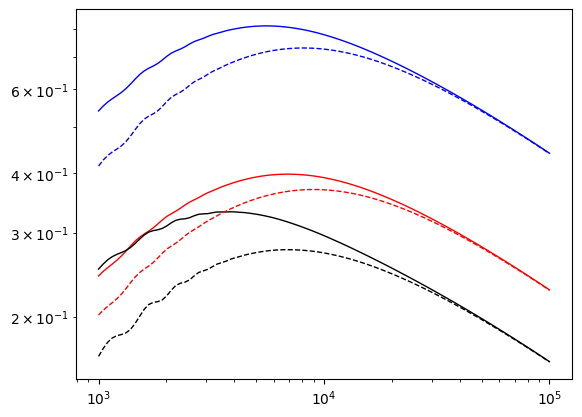

In [107]:
plt.loglog(llistpl,C21r5001, label = '$z=30$', color = 'blue', linewidth = 1, linestyle = '-', zorder = 10)
plt.loglog(llistpl,C21r3001, label = '$z=30$', color = 'red', linewidth = 1, linestyle = '-', zorder = 10)
plt.loglog(llistpl,C21r10001, label = '$z=30$', color = 'black', linewidth = 1, linestyle = '-', zorder = 10)

plt.loglog(llistpl,C21r5001_novel, label = '$z=30$', color = 'blue', linewidth = 1, linestyle = '--', zorder = 10)
plt.loglog(llistpl,C21r3001_novel, label = '$z=30$', color = 'red', linewidth = 1, linestyle = '--', zorder = 10)
plt.loglog(llistpl,C21r10001_novel, label = '$z=30$', color = 'black', linewidth = 1, linestyle = '--', zorder = 10)

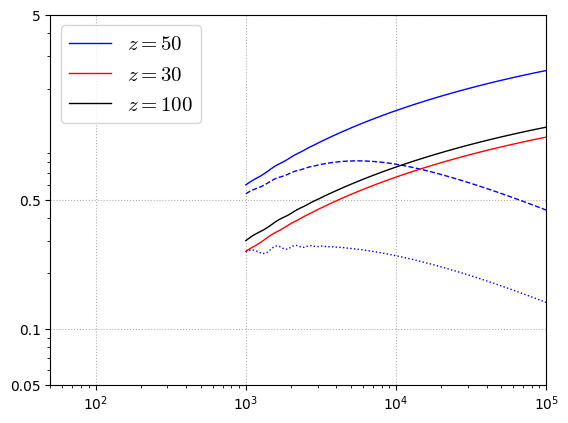

In [108]:
plt.loglog(llistpl,C21r5001,  color = 'blue', linewidth = 1, linestyle = '--', zorder = 10)
# # plt.plot(llistpl,C21r50w01plt, color = 'royalblue', linewidth = 1, linestyle = '--', zorder = 10)

plt.loglog(llistpl,C21r501, color = 'blue', linewidth = 1, linestyle = ':', zorder = 10)
# plt.plot(llistpl,C21r50w1plt, color = 'royalblue', linewidth = 1, linestyle = '--', zorder = 10)

plt.loglog(llistpl,C21r500, label = '$z=50$', color = 'blue', linewidth = 1, linestyle = '-', zorder = 10)

plt.loglog(llistpl,C21r300, label = '$z=30$', color = 'red', linewidth = 1, linestyle = '-', zorder = 10)

plt.loglog(llistpl,C21r1000, label = '$z=100$', color = 'black', linewidth = 1, linestyle = '-', zorder = 10)

# plt.xticks([100,300,1000,3000,1e4,3e4,1e5],[100,300,1000,3000,1e4,3e4,1e5])
plt.xlim(50,1e5)
plt.legend(fontsize=15)
plt.yticks([0.05,0.1,0.5,5],[0.05,0.1,0.5,5])
plt.grid(linestyle=":")
plt.show()

In [109]:
# for plots

def kplot(x):
    value = x/r50
    return value

def invkplot(x):
    value = x*r50
    return value

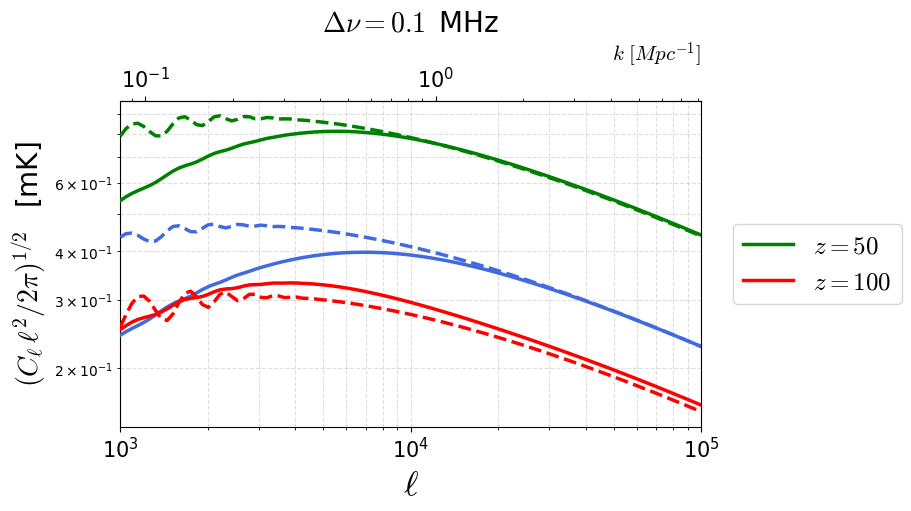

In [113]:
# plot 21-cm PS exact vs limber $\Delta \nu = 0.1 \,$ MHz

fig, ax1 = plt.subplots(layout='constrained',figsize=(9, 5))


ax1.set_xscale('log')

ax1.set_yscale('log')


plt.xlim(1e3,1e5)
# ax1.plot(llistpl,C21r3001_novel, label = '$z=30$', color = 'royalblue', linewidth = 2.5, linestyle = ':', zorder = 10)
ax1.plot(llistpl,C21r3001, color = 'royalblue', linewidth = 2.5, linestyle = '-', zorder = 10)
ax1.plot(llistpl,C21r30w01plt, color = 'royalblue', linewidth = 2.5, linestyle = '--', zorder = 10)

# ax1.plot(llistpl,C21r5001_novel, color = 'green', linewidth = 2.5, linestyle = ':', zorder = 10)
ax1.plot(llistpl,C21r5001, label = '$z=50$', color = 'green', linewidth = 2.5, linestyle = '-', zorder = 10)
ax1.plot(llistpl,C21r50w01plt, color = 'green', linewidth = 2.5, linestyle = '--', zorder = 10)

# ax1.plot(llistpl,C21r10001_novel, color = 'red', linewidth = 2.5, linestyle = ':', zorder = 10)
ax1.plot(llistpl,C21r10001, label = '$z=100$', color = 'red', linewidth = 2.5, linestyle = '-', zorder = 10)
ax1.plot(llistpl,C21r100w01plt, color = 'red', linewidth = 2.5, linestyle = '--', zorder = 10)

ax1.set_xlabel(r'$\ell$', fontsize=25)
ax1.set_ylabel(r'$(C_\ell \, \ell^2/2\pi)^{1/2} \, $  [mK]', fontsize=20)
ax1.legend(bbox_to_anchor=(1.20, 0.5), loc='center', ncol = 1, borderaxespad=0., fontsize=18)#(loc='best', fontsize=20)

ax1.set_title(r'$\Delta \nu = 0.1 \,$ MHz', fontsize=20)

ax1.tick_params(labelsize=15)
plt.grid(True, which='both',linestyle='--', alpha = 0.4)


ax2 = ax1.secondary_xaxis("top",functions=(kplot,invkplot))
ax2.set_xlabel(r'$k \,\, [Mpc^{-1}]$', fontsize=15, loc="right")
ax2.tick_params(labelsize=15)

plt.savefig("plots/21cm_power_0.1.pdf", dpi=300, bbox_inches='tight')
plt.show()

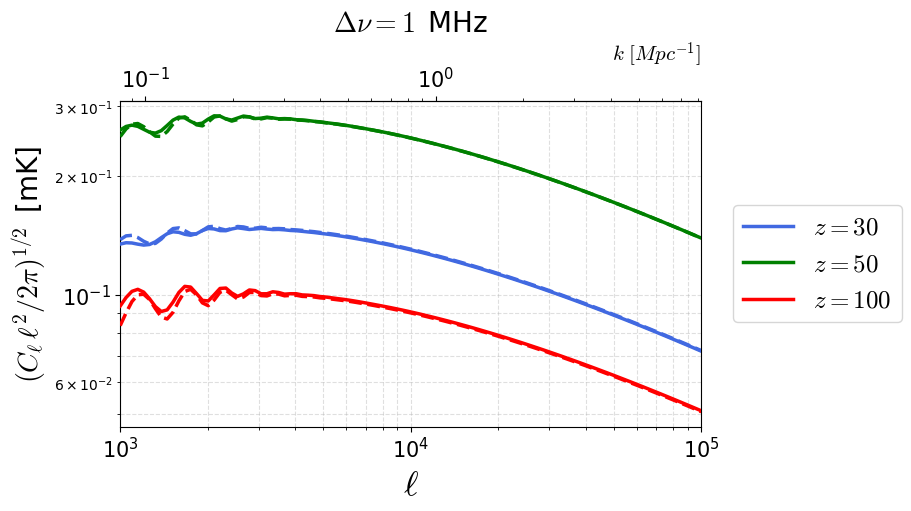

In [114]:
# plot 21-cm PS exact vs limber $\Delta \nu = 1 \,$ MHz

fig, ax1 = plt.subplots(layout='constrained',figsize=(9, 5))


ax1.set_xscale('log')

ax1.set_yscale('log')


plt.xlim(1e3,1e5)

ax1.plot(llistpl,C21r301, label = '$z=30$', color = 'royalblue', linewidth = 2.5, linestyle = '-', zorder = 10)
ax1.plot(llistpl,C21r30w1plt, color = 'royalblue', linewidth = 2.5, linestyle = '--', zorder = 10)

ax1.plot(llistpl,C21r501, label = '$z=50$', color = 'green', linewidth = 2.5, linestyle = '-', zorder = 10)
ax1.plot(llistpl,C21r50w1plt, color = 'green', linewidth = 2.5, linestyle = '--', zorder = 10)

ax1.plot(llistpl,C21r1001, label = '$z=100$', color = 'red', linewidth = 2.5, linestyle = '-', zorder = 10)
ax1.plot(llistpl,C21r100w1plt, color = 'red', linewidth = 2.5, linestyle = '--', zorder = 10)

ax1.set_xlabel(r'$\ell$', fontsize=25)
ax1.set_ylabel(r'$(C_\ell \, \ell^2/2\pi)^{1/2} \, $ [mK]', fontsize=20)
ax1.legend(bbox_to_anchor=(1.20, 0.5), loc='center', ncol = 1, borderaxespad=0., fontsize=18)#(loc='best', fontsize=20)

ax1.set_title(r'$\Delta \nu = 1 \,$ MHz', fontsize=20)

ax1.tick_params(labelsize=15)
plt.grid(True, which='both',linestyle='--', alpha = 0.4)


ax2 = ax1.secondary_xaxis("top",functions=(kplot,invkplot))
ax2.set_xlabel(r'$k \,\, [Mpc^{-1}]$', fontsize=15, loc="right")
ax2.tick_params(labelsize=15)

plt.savefig("plots/21cm_power_1.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Fisher matrix forecasts, SNR's

In [147]:
# Fisher terms 21-21-T primordial

def Fisher_prim_T_30(l1,l2,l3): 
    D = 1
    if l1 == l2:
        D=2
    val = B_prim_I1_T_30(l1,l2,l3)**2/np.array(C21r30w01[l1-10000])/np.array(C21r30w01[l2-10000])/cTTspectra[l3-2]/D 
    return val

def Fisher_prim_T_50(l1,l2,l3): 
    D = 1
    if l1 == l2:
        D=2
    val = B_prim_I1_T_50(l1,l2,l3)**2/np.array(C21r50w01[l1-10000])/np.array(C21r50w01[l2-10000])/cTTspectra[l3-2]/D      
    return val

def Fisher_prim_T_100(l1,l2,l3): 
    D = 1
    if l1 == l2:
        D=2
    val = B_prim_I1_T_100(l1,l2,l3)**2/np.array(C21r100w01[l1-10000])/np.array(C21r100w01[l2-10000])/cTTspectra[l3-2]/D      
    return val

In [148]:
# Fisher terms 21-21-T secondary (only I1)

def Fisher_sec_T_30(l1,l2,l3): 
    D = 1
    if l1 == l2:
        D=2
    val = (B_sec_I1_T_30(l1,l2,l3))**2/np.array(C21r30w01[l1-10000])/np.array(C21r30w01[l2-10000])/cTTspectra[l3-2]/D      
    return val

def Fisher_sec_T_50(l1,l2,l3): 
    D = 1
    if l1 == l2:
        D=2
    val = (B_sec_I1_T_50(l1,l2,l3))**2/np.array(C21r50w01[l1-10000])/np.array(C21r50w01[l2-10000])/cTTspectra[l3-2]/D      
    return val

def Fisher_sec_T_100(l1,l2,l3): 
    D = 1
    if l1 == l2:
        D=2
    val = (B_sec_I1_T_100(l1,l2,l3))**2/np.array(C21r100w01[l1-10000])/np.array(C21r100w01[l2-10000])/cTTspectra[l3-2]/D      
    return val


In [149]:
# Fisher terms 21-21-T + 21-21-E primordial

def Fisher_prim_TE_30(l1,l2,l3): 
    D = 1
    if l1 == l2:
        D=2
    B = B_prim_I1_T_30(l1,l2,l3)
    Bpol = B_prim_I1_E_30(l1,l2,l3)
    val1 = B**2*cEEspectra[l3-2]/np.array(C21r30w01[l1-10000])/np.array(C21r30w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val2 = Bpol**2*cTTspectra[l3-2]/np.array(C21r30w01[l1-10000])/np.array(C21r30w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val3 = -2*B*Bpol*cETspectra[l3-2]/np.array(C21r30w01[l1-10000])/np.array(C21r30w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    return val1+val2+val3


def Fisher_prim_TE_50(l1,l2,l3): 
    D = 1
    if l1 == l2:
        D=2
    B = B_prim_I1_T_50(l1,l2,l3)
    Bpol = B_prim_I1_E_50(l1,l2,l3)
    val1 = B**2*cEEspectra[l3-2]/np.array(C21r50w01[l1-10000])/np.array(C21r50w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val2 = Bpol**2*cTTspectra[l3-2]/np.array(C21r50w01[l1-10000])/np.array(C21r50w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val3 = -2*B*Bpol*cETspectra[l3-2]/np.array(C21r50w01[l1-10000])/np.array(C21r50w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    return val1+val2+val3


def Fisher_prim_TE_100(l1,l2,l3): 
    D = 1
    if l1 == l2:
        D=2
    B = B_prim_I1_T_100(l1,l2,l3)
    Bpol = B_prim_I1_E_100(l1,l2,l3)
    val1 = B**2*cEEspectra[l3-2]/np.array(C21r100w01[l1-10000])/np.array(C21r100w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val2 = Bpol**2*cTTspectra[l3-2]/np.array(C21r100w01[l1-10000])/np.array(C21r100w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val3 = -2*B*Bpol*cETspectra[l3-2]/np.array(C21r100w01[l1-10000])/np.array(C21r100w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    return val1+val2+val3

In [150]:
# Fisher terms 21-21-T + 21-21-E secondary (only I1)

def Fisher_sec_TE_30(l1,l2,l3): 
    D = 1
    if l1 == l2: 
        D=2 
    B = B_sec_I1_T_30(l1,l2,l3)
    Bpol = B_sec_I1_E_30(l1,l2,l3)
    val1 = B**2*cEEspectra[l3-2]/np.array(C21r30w01[l1-10000])/np.array(C21r30w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val2 = Bpol**2*cTTspectra[l3-2]/np.array(C21r30w01[l1-10000])/np.array(C21r30w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val3 = -2*B*Bpol*cETspectra[l3-2]/np.array(C21r30w01[l1-10000])/np.array(C21r30w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    return val1+val2+val3


def Fisher_sec_TE_50(l1,l2,l3): 
    D = 1
    if l1 == l2:
        D=2
    B = B_sec_I1_T_50(l1,l2,l3)
    Bpol = B_sec_I1_E_50(l1,l2,l3)
    val1 = B**2*cEEspectra[l3-2]/np.array(C21r50w01[l1-10000])/np.array(C21r50w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val2 = Bpol**2*cTTspectra[l3-2]/np.array(C21r50w01[l1-10000])/np.array(C21r50w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val3 = -2*B*Bpol*cETspectra[l3-2]/np.array(C21r50w01[l1-10000])/np.array(C21r50w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    return val1+val2+val3


def Fisher_sec_TE_100(l1,l2,l3): 
    D = 1
    if l1 == l2:
        D=2
    B = B_sec_I1_T_100(l1,l2,l3)
    Bpol = B_sec_I1_E_100(l1,l2,l3)
    val1 = B**2*cEEspectra[l3-2]/np.array(C21r100w01[l1-10000])/np.array(C21r100w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val2 = Bpol**2*cTTspectra[l3-2]/np.array(C21r100w01[l1-10000])/np.array(C21r100w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val3 = -2*B*Bpol*cETspectra[l3-2]/np.array(C21r100w01[l1-10000])/np.array(C21r100w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    return val1+val2+val3

In [157]:
from tqdm import tqdm

def Fisher_l3(Fisher,l3,llist2):
    val = np.zeros((len(llist2)))
    for i1 in tqdm(range(len(llist2)),disable=(l3!=l3list[-1])):
        l1 = llist2[i1]
        l2list = np.arange(l1,np.fmin(l1+l3,llist2[-1])+1)
        for l2 in l2list:
            if (l2+l1+l3) % 2== 0:
                val[i1] += Fisher(l1,l2,l3) 
    return val.cumsum()

In [159]:
FisherInfo_prim_T_30 = np.array(Parallel(n_jobs=-1,verbose=0)([delayed(Fisher_l3)(Fisher_prim_T_30,l3,llist2) for l3 in l3list])).cumsum(0)
FisherInfo_prim_T_50 = np.array(Parallel(n_jobs=-1,verbose=0)([delayed(Fisher_l3)(Fisher_prim_T_50,l3,llist2) for l3 in l3list])).cumsum(0)
FisherInfo_prim_T_100 = np.array(Parallel(n_jobs=-1,verbose=0)([delayed(Fisher_l3)(Fisher_prim_T_100,l3,llist2) for l3 in l3list])).cumsum(0)

100%|██████████| 10001/10001 [01:08<00:00, 145.52it/s]


In [160]:
FisherInfo_sec_T_30 = np.array(Parallel(n_jobs=-1,verbose=0)([delayed(Fisher_l3)(Fisher_sec_T_30,l3,llist2) for l3 in l3list])).cumsum(0)
FisherInfo_sec_T_50 = np.array(Parallel(n_jobs=-1,verbose=0)([delayed(Fisher_l3)(Fisher_sec_T_50,l3,llist2) for l3 in l3list])).cumsum(0)
FisherInfo_sec_T_100 = np.array(Parallel(n_jobs=-1,verbose=0)([delayed(Fisher_l3)(Fisher_sec_T_100,l3,llist2) for l3 in l3list])).cumsum(0)

100%|██████████| 10001/10001 [01:15<00:00, 132.24it/s]


In [199]:
FisherInfo_prim_TE_30 = np.array(Parallel(n_jobs=-1,verbose=0)([delayed(Fisher_l3)(Fisher_prim_TE_30,l3,llist2) for l3 in l3list])).cumsum(0)
FisherInfo_prim_TE_50 = np.array(Parallel(n_jobs=-1,verbose=0)([delayed(Fisher_l3)(Fisher_prim_TE_50,l3,llist2) for l3 in l3list])).cumsum(0)
FisherInfo_prim_TE_100 = np.array(Parallel(n_jobs=-1,verbose=0)([delayed(Fisher_l3)(Fisher_prim_TE_100,l3,llist2) for l3 in l3list])).cumsum(0)

100%|██████████| 10001/10001 [02:15<00:00, 73.83it/s]


In [200]:
FisherInfo_sec_TE_30 = np.array(Parallel(n_jobs=-1,verbose=0)([delayed(Fisher_l3)(Fisher_sec_TE_30,l3,llist2) for l3 in l3list])).cumsum(0)
FisherInfo_sec_TE_50 = np.array(Parallel(n_jobs=-1,verbose=0)([delayed(Fisher_l3)(Fisher_sec_TE_50,l3,llist2) for l3 in l3list])).cumsum(0)
FisherInfo_sec_TE_100 = np.array(Parallel(n_jobs=-1,verbose=0)([delayed(Fisher_l3)(Fisher_sec_TE_100,l3,llist2) for l3 in l3list])).cumsum(0)

100%|██████████| 10001/10001 [02:34<00:00, 64.73it/s]


In [238]:
np.save(f"output_data/FisherInfo_prim_T_30_l3max{l3list[-1]}_l1max{llist2[-1]}",FisherInfo_prim_T_30)
np.save(f"output_data/FisherInfo_prim_T_50_l3max{l3list[-1]}_l1max{llist2[-1]}",FisherInfo_prim_T_50)
np.save(f"output_data/FisherInfo_prim_T_100_l3max{l3list[-1]}_l1max{llist2[-1]}",FisherInfo_prim_T_100)

np.save(f"output_data/FisherInfo_sec_T_30_l3max{l3list[-1]}_l1max{llist2[-1]}",FisherInfo_sec_T_30)
np.save(f"output_data/FisherInfo_sec_T_50_l3max{l3list[-1]}_l1max{llist2[-1]}",FisherInfo_sec_T_50)
np.save(f"output_data/FisherInfo_sec_T_100_l3max{l3list[-1]}_l1max{llist2[-1]}",FisherInfo_sec_T_100)

np.save(f"output_data/FisherInfo_prim_TE_30_l3max{l3list[-1]}_l1max{llist2[-1]}",FisherInfo_prim_TE_30)
np.save(f"output_data/FisherInfo_prim_TE_50_l3max{l3list[-1]}_l1max{llist2[-1]}",FisherInfo_prim_TE_50)
np.save(f"output_data/FisherInfo_prim_TE_100_l3max{l3list[-1]}_l1max{llist2[-1]}",FisherInfo_prim_TE_100)

np.save(f"output_data/FisherInfo_sec_TE_30_l3max{l3list[-1]}_l1max{llist2[-1]}",FisherInfo_sec_TE_30)
np.save(f"output_data/FisherInfo_sec_TE_50_l3max{l3list[-1]}_l1max{llist2[-1]}",FisherInfo_sec_TE_50)
np.save(f"output_data/FisherInfo_sec_TE_100_l3max{l3list[-1]}_l1max{llist2[-1]}",FisherInfo_sec_TE_100)

In [239]:
FisherInfo_prim_T_30 = np.load(f"output_data/FisherInfo_prim_T_30_l3max{l3list[-1]}_l1max{llist2[-1]}.npy")
FisherInfo_prim_T_50 = np.load(f"output_data/FisherInfo_prim_T_50_l3max{l3list[-1]}_l1max{llist2[-1]}.npy")
FisherInfo_prim_T_100 = np.load(f"output_data/FisherInfo_prim_T_100_l3max{l3list[-1]}_l1max{llist2[-1]}.npy")

FisherInfo_sec_T_30 = np.load(f"output_data/FisherInfo_sec_T_30_l3max{l3list[-1]}_l1max{llist2[-1]}.npy")
FisherInfo_sec_T_50 = np.load(f"output_data/FisherInfo_sec_T_50_l3max{l3list[-1]}_l1max{llist2[-1]}.npy")
FisherInfo_sec_T_100 = np.load(f"output_data/FisherInfo_sec_T_100_l3max{l3list[-1]}_l1max{llist2[-1]}.npy")

FisherInfo_prim_TE_30 = np.load(f"output_data/FisherInfo_prim_TE_30_l3max{l3list[-1]}_l1max{llist2[-1]}.npy")
FisherInfo_prim_TE_50 = np.load(f"output_data/FisherInfo_prim_TE_50_l3max{l3list[-1]}_l1max{llist2[-1]}.npy")
FisherInfo_prim_TE_100 = np.load(f"output_data/FisherInfo_prim_TE_100_l3max{l3list[-1]}_l1max{llist2[-1]}.npy")

FisherInfo_sec_TE_30 = np.load(f"output_data/FisherInfo_sec_TE_30_l3max{l3list[-1]}_l1max{llist2[-1]}.npy")
FisherInfo_sec_TE_50 = np.load(f"output_data/FisherInfo_sec_TE_50_l3max{l3list[-1]}_l1max{llist2[-1]}.npy")
FisherInfo_sec_TE_100 =np.load(f"output_data/FisherInfo_sec_TE_100_l3max{l3list[-1]}_l1max{llist2[-1]}.npy")

# SNR ESTIMATED IN AN APPROXIMATED WAY

In [244]:
# SNR computed with approximated formula 53 of the paper

def SNR30(l3list):
    SNR = np.zeros(len(l3list))
    for i3 in range(len(l3list)):
        if l3list[i3] == 2 or l3list[i3] == 3:
            N = 2
        if l3list[i3] == 4 or l3list[i3] == 5:
            N = 3
        if l3list[i3] == 6 or l3list[i3] == 7:
            N = 4
        if l3list[i3] == 8 or l3list[i3] == 9:
            N = 5
        if l3list[i3] == 10 or l3list[i3] == 11:
            N = 6
        SNR[i3] =  SNR[i3-1] + R30T[i3]*N
    SNR = 9.5e5*np.sqrt(SNR)*(llist2[-1]/1e5)
    return SNR

def SNR50(l3list):
    SNR = np.zeros(len(l3list))
    for i3 in range(len(l3list)):
        if l3list[i3] == 2 or l3list[i3] == 3:
            N = 2
        if l3list[i3] == 4 or l3list[i3] == 5:
            N = 3
        if l3list[i3] == 6 or l3list[i3] == 7:
            N = 4
        if l3list[i3] == 8 or l3list[i3] == 9:
            N = 5
        if l3list[i3] == 10 or l3list[i3] == 11:
            N = 6
        SNR[i3] =  SNR[i3-1] + R50T[i3]*N
    SNR = 9.5e5*np.sqrt(SNR)*(llist2[-1]/1e5)
    return SNR

def SNR100(l3list):
    SNR = np.zeros(len(l3list))
    for i3 in range(len(l3list)):
        if l3list[i3] == 2 or l3list[i3] == 3:
            N = 2
        if l3list[i3] == 4 or l3list[i3] == 5:
            N = 3
        if l3list[i3] == 6 or l3list[i3] == 7:
            N = 4
        if l3list[i3] == 8 or l3list[i3] == 9:
            N = 5
        if l3list[i3] == 10 or l3list[i3] == 11:
            N = 6
        SNR[i3] =  SNR[i3-1] + R100T[i3]*N
    SNR = 9.5e5*np.sqrt(SNR)*(llist2[-1]/1e5)
    return SNR

snr30 = SNR30(l3list)
snr50 = SNR50(l3list)
snr100 = SNR100(l3list)

# Plots SNR's

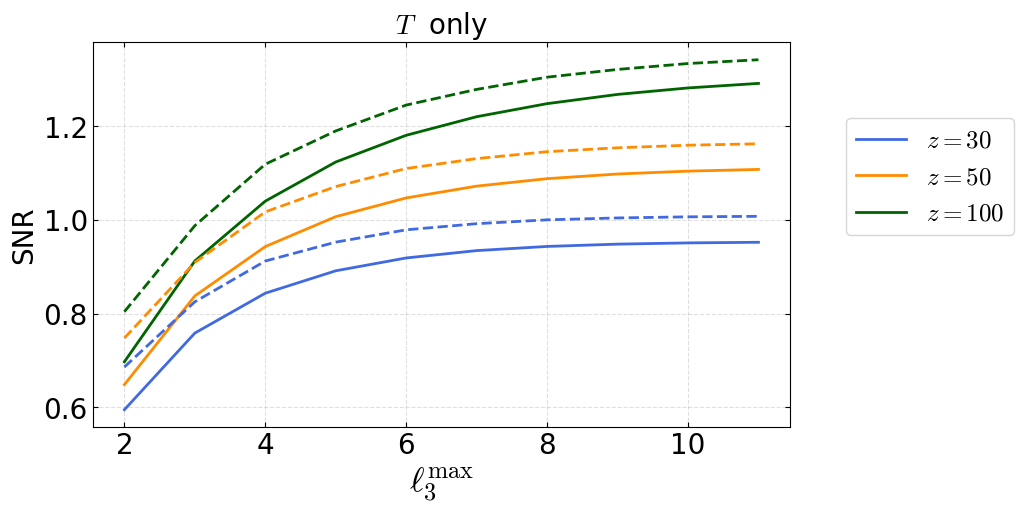

In [245]:
# T only vs l3max

plt.figure(figsize=(9,5))

plt.yscale("linear")

#plt.xlim(1e3,1e5)

plt.plot(l3list, FisherInfo_prim_T_30[:,-1]**.5,label = r'$z=30$', color = 'royalblue', linewidth = 2, linestyle = '-', zorder = 10)
plt.plot(l3list, FisherInfo_prim_T_50[:,-1]**.5, label = r'$z=50$', color = 'darkorange', linewidth = 2, linestyle = '-', zorder = 10)
plt.plot(l3list, FisherInfo_prim_T_100[:,-1]**.5, label = r'$z=100$', color = 'darkgreen', linewidth = 2, linestyle = '-', zorder = 10)

plt.plot(l3list,snr30, color = 'royalblue', linewidth = 2, linestyle = '--', zorder = 10)
plt.plot(l3list,snr50, color = 'darkorange', linewidth = 2, linestyle = '--', zorder = 10)
plt.plot(l3list,snr100, color = 'darkgreen', linewidth = 2, linestyle = '--', zorder = 10)



plt.xlabel(r'$\ell_3^{\rm max}$', fontsize=25)
plt.ylabel(r'SNR', fontsize=20)
plt.legend(bbox_to_anchor=(1.20, 0.65), loc='center', ncol = 1, borderaxespad=0., fontsize=18)#(loc='best', fontsize=20)

plt.title(r'$T \, \,$ only', fontsize=20)


plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
plt.grid(True, which='both',linestyle='--', alpha = 0.4)

# plt.ylim([1e-13,7e1])

# ax1.set_ylim([1.4e-6,6.2e-6])
plt.savefig("plots/squeez_DeltafNLvsl3.pdf", dpi=300, bbox_inches='tight')
plt.show()

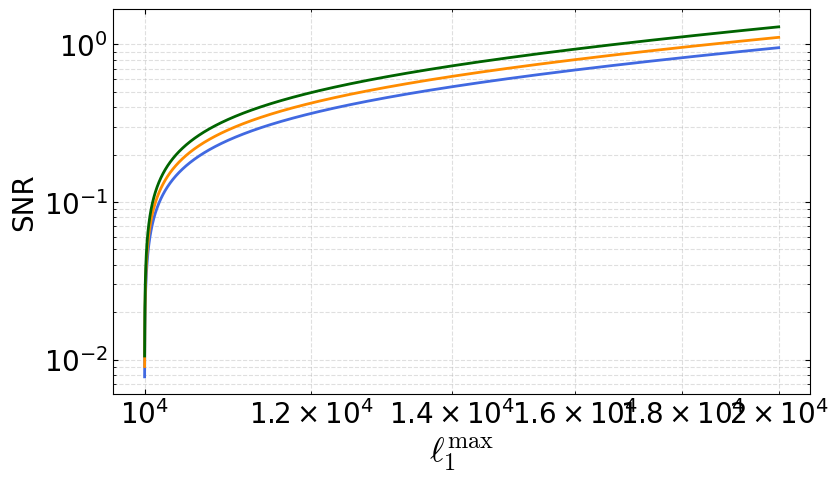

In [246]:
# T only vs l1max

plt.figure(figsize=(9,5))

plt.xscale("log")
plt.yscale("log")


#plt.xlim(1e3,1e5)

plt.plot(llist2, FisherInfo_prim_T_30[-1]**.5, label = r'$z=30$', color = 'royalblue', linewidth = 2, linestyle = '-', zorder = 10)
plt.plot(llist2, FisherInfo_prim_T_50[-1]**.5, label = r'$z=50$', color = 'darkorange', linewidth = 2, linestyle = '-', zorder = 10)
plt.plot(llist2, FisherInfo_prim_T_100[-1]**.5, label = r'$z=100$', color = 'darkgreen', linewidth = 2, linestyle = '-', zorder = 10)


plt.xlabel(r'$\ell_1^{\rm max}$', fontsize=25)
plt.ylabel(r'SNR', fontsize=20)
#plt.legend(bbox_to_anchor=(1.20, 0.65), loc='center', ncol = 1, borderaxespad=0., fontsize=18)#(loc='best', fontsize=20)

#plt.title(r'$T \, \,$ only', fontsize=20)

plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
plt.grid(True, which='both',linestyle='--', alpha = 0.4)

# plt.ylim([1e-13,7e1])

# ax1.set_ylim([1.4e-6,6.2e-6])
plt.savefig("plots/squeez_DeltafNLvsl1.pdf", dpi=300, bbox_inches='tight')
plt.show()

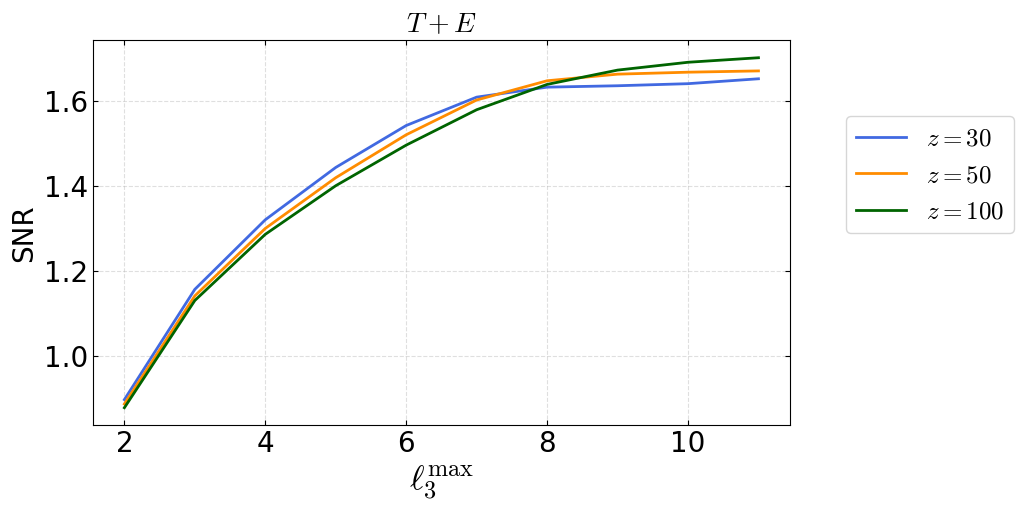

In [247]:
# T+E vs l3max

plt.figure(figsize=(9,5))

plt.yscale("linear")

#plt.xlim(1e3,1e5)

plt.plot(l3list, FisherInfo_prim_TE_30[:,-1]**.5,label = r'$z=30$', color = 'royalblue', linewidth = 2, linestyle = '-', zorder = 10)
plt.plot(l3list, FisherInfo_prim_TE_50[:,-1]**.5, label = r'$z=50$', color = 'darkorange', linewidth = 2, linestyle = '-', zorder = 10)
plt.plot(l3list, FisherInfo_prim_TE_100[:,-1]**.5, label = r'$z=100$', color = 'darkgreen', linewidth = 2, linestyle = '-', zorder = 10)


plt.xlabel(r'$\ell_3^{\rm max}$', fontsize=25)
plt.ylabel(r'SNR', fontsize=20)
plt.legend(bbox_to_anchor=(1.20, 0.65), loc='center', ncol = 1, borderaxespad=0., fontsize=18)#(loc='best', fontsize=20)

plt.title(r'$T+E$', fontsize=20)


plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
plt.grid(True, which='both',linestyle='--', alpha = 0.4)

# plt.ylim([1e-13,7e1])

# ax1.set_ylim([1.4e-6,6.2e-6])
plt.savefig("plots/squeez_DeltafNLvsl3TpE.pdf", dpi=300, bbox_inches='tight')
plt.show()

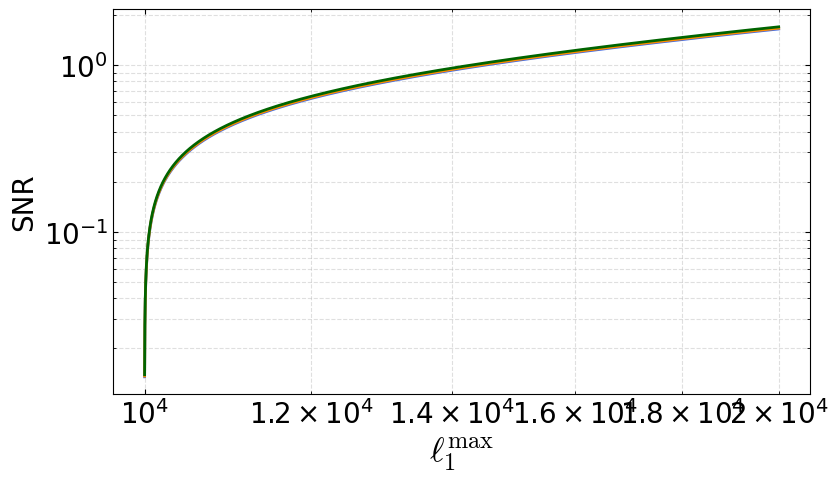

In [248]:
# T+E vs l1max

plt.figure(figsize=(9,5))

plt.xscale("log")
plt.yscale("log")


#plt.xlim(1e3,1e5)

plt.plot(llist2, FisherInfo_prim_TE_30[-1]**.5, label = r'$z=30$', color = 'royalblue', linewidth = 2, linestyle = '-', zorder = 10)
plt.plot(llist2, FisherInfo_prim_TE_50[-1]**.5, label = r'$z=50$', color = 'darkorange', linewidth = 2, linestyle = '-', zorder = 10)
plt.plot(llist2, FisherInfo_prim_TE_100[-1]**.5, label = r'$z=100$', color = 'darkgreen', linewidth = 2, linestyle = '-', zorder = 10)


plt.xlabel(r'$\ell_1^{\rm max}$', fontsize=25)
plt.ylabel(r'SNR', fontsize=20)
#plt.legend(bbox_to_anchor=(1.20, 0.65), loc='center', ncol = 1, borderaxespad=0., fontsize=18)#(loc='best', fontsize=20)

#plt.title(r'$T \, \,$ only', fontsize=20)

plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
plt.grid(True, which='both',linestyle='--', alpha = 0.4)

# plt.ylim([1e-13,7e1])

# ax1.set_ylim([1.4e-6,6.2e-6])
plt.savefig("plots/squeez_DeltafNLvsl1TpE.pdf", dpi=300, bbox_inches='tight')
plt.show()

# BIAS TO F_NL^LOC MEASURE 

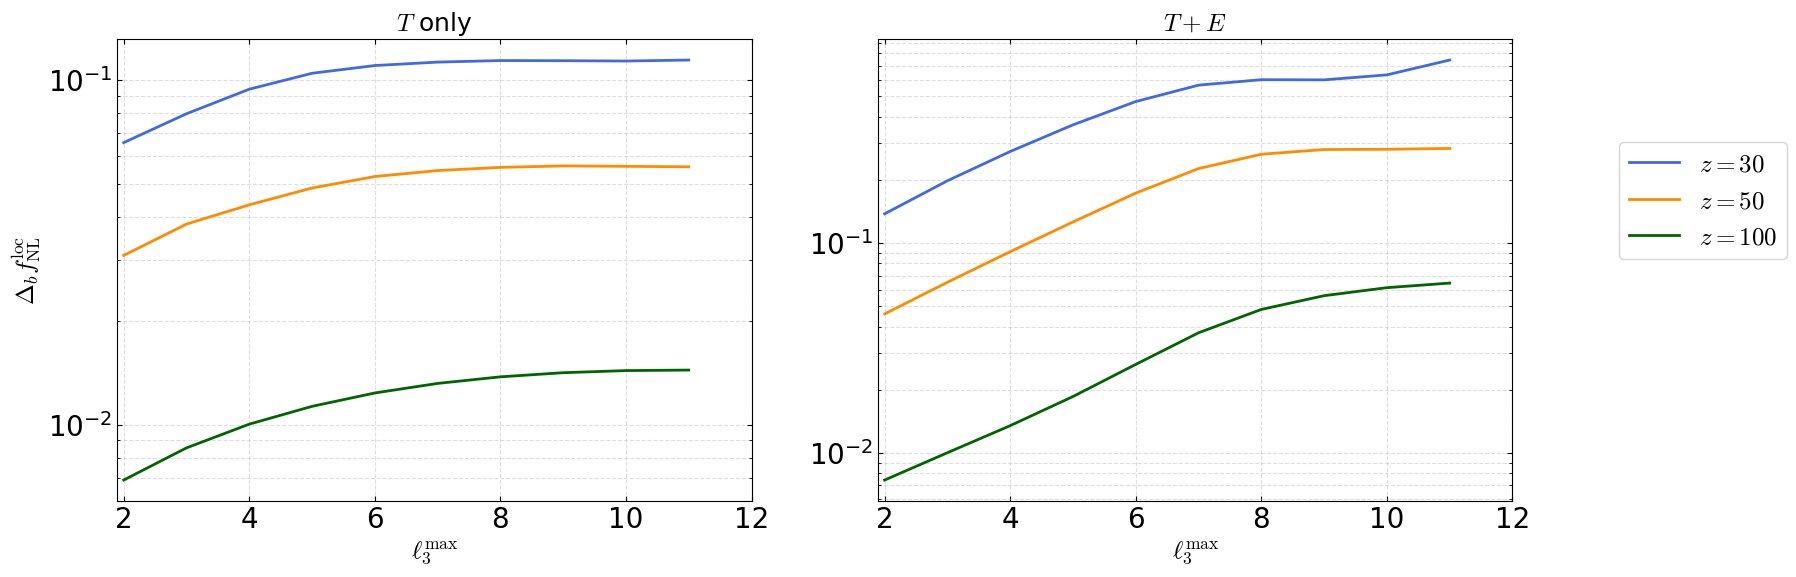

In [249]:
# Plot of estimated bias vs l3max
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
                        

ax1.set_title(r'$T$ only', fontsize=18)
ax2.set_title(r'$T+E$', fontsize=18)


ax1.set_xlabel(r'$\ell^{\rm max}_3$', fontsize=18)
ax2.set_xlabel(r'$\ell^{\rm max}_3$', fontsize=18)


ax1.set_xlim(1.9,12)
ax2.set_xlim(1.9,12)


ax1.set_ylabel(r'$\Delta_b f_{\rm NL}^{\rm loc}$', fontsize=18)


ax1.set_yscale('log')
ax2.set_yscale('log')


ax1.plot(l3list,np.sqrt(FisherInfo_sec_T_30[:,-1]/FisherInfo_prim_T_30[:,-1]), label = r'$z=30$', color = 'royalblue', linewidth = 2, linestyle = '-', zorder = 10)
ax1.plot(l3list,np.sqrt(FisherInfo_sec_T_50[:,-1]/FisherInfo_prim_T_50[:,-1]), label = r'$z=50$', color = 'darkorange', linewidth = 2, linestyle = '-', zorder = 10)
ax1.plot(l3list,np.sqrt(FisherInfo_sec_T_100[:,-1]/FisherInfo_prim_T_100[:,-1]), label = r'$z=100$', color = 'darkgreen', linewidth = 2, linestyle = '-', zorder = 10)

ax2.plot(l3list,np.sqrt(FisherInfo_sec_TE_30[:,-1]/FisherInfo_prim_TE_30[:,-1]), label = r'$z=30$', color = 'royalblue', linewidth = 2, linestyle = '-', zorder = 10)
ax2.plot(l3list,np.sqrt(FisherInfo_sec_TE_50[:,-1]/FisherInfo_prim_TE_50[:,-1]), label = r'$z=50$', color = 'darkorange', linewidth = 2, linestyle = '-', zorder = 10)
ax2.plot(l3list,np.sqrt(FisherInfo_sec_TE_100[:,-1]/FisherInfo_prim_TE_100[:,-1]), label = r'$z=100$', color = 'darkgreen', linewidth = 2, linestyle = '-', zorder = 10)


ax2.legend(bbox_to_anchor=(1.30, 0.65), loc='center', ncol = 1, borderaxespad=0., fontsize=18)#(loc='best', fontsize=20)


ax1.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
ax1.grid(True, which='both',linestyle='--', alpha = 0.4)

ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
ax2.grid(True, which='both',linestyle='--', alpha = 0.4)

# plt.ylim([1e-13,7e1])

# ax1.set_ylim([1.4e-6,6.2e-6])
plt.savefig("plots/biasfNLvsl3.pdf", dpi=300, bbox_inches='tight')
plt.show()